# Stock Market News Impact Analysis

## Explainer Notebook

This project analyzes the relationship between news sentiment and stock price movements for major tech companies. We collect news articles from multiple sources, perform sentiment analysis, and study correlations with stock price changes. The pipeline consists of several key components:

1. Data Collection from Multiple Sources
2. Web Scraping for Full Article Content
3. Web Scraping for Reddit Data
4. Data Cleaning of webscraped data
5. Acquiring Sentiment Score (Transformer Inference)
6. Sentiment Analysis
7. Stock Price Analysis (Gradients)
8. Locality Sensitivity Hashing & Clustering
9. PCY Algorithm
10. Correlation Analysis

Let's explore each component in detail.


**NB:** If you want to your our code you can download the required data from this GDrive link (it will expire in 30 days). Note, however that we will not be sharing API keys for the data fetching code for obvious reasons. [Project Data](https://drive.google.com/drive/folders/1q2D3TeZ4BIz0AIECRm3v0Dy6xDwIVe8Z?usp=sharing)

## 1. Data Collection

### 1.1 Finnhub API Collection
We use Finnhub's financial API to gather news articles for seven major tech companies (AAPL, TSLA, GOOGL, MSFT, META, AMZN, NVDA). The collection process:
- Handles API rate limiting with intelligent delays
- Processes data in 7-day chunks to manage memory
- Stores both raw JSON and processed CSV formats
- Includes error handling and retry mechanisms

In [ ]:
import finnhub
import json
import time
from datetime import datetime, timedelta
import configparser
import os
import pandas as pd

# Define base path
BASE_PATH = r'C:\Users\jbh\Desktop\CompTools\StockMarketNewsImpact\MarketNews'

def fetch_finnhub_news():
    # Initialize the config parser
    config = configparser.ConfigParser()
    config.read(os.path.join(BASE_PATH, 'config', 'config.ini'))

    # Retrieve the API key from the config file
    api_key = config.get('finnhub', 'api_key')

    # Initialize the Finnhub client
    finnhub_client = finnhub.Client(api_key=api_key)

    # Parameters
    symbols = ['AAPL', 'TSLA', 'GOOGL', 'MSFT', 'META', 'AMZN', 'NVDA']
    year = '2024'
    start_date = f'{year}-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')  # Current date

    all_articles = []

    def fetch_company_news(symbol, from_date, to_date):
        """Fetch news for a company with rate limiting and error handling"""
        try:
            news = finnhub_client.company_news(symbol, _from=from_date, to=to_date)
            time.sleep(1)  # Rate limiting - 1 second delay between requests
            return news
        except Exception as e:
            print(f"Error fetching news for {symbol}: {str(e)}")
            time.sleep(60)  # If error occurs, wait longer
            return []

    def convert_timestamp(timestamp):
        """Convert timestamp to datetime string, handling both seconds and milliseconds formats"""
        try:
            # Try converting directly (assuming seconds)
            return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        except (OSError, ValueError):
            try:
                # Try converting from milliseconds
                return datetime.fromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H:%M:%S')
            except:
                # Return current time if conversion fails
                print(f"Warning: Invalid timestamp {timestamp}, using current time")
                return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Fetch news for each company
    for symbol in symbols:
        print(f"Fetching news for {symbol}...")
        
        # Fetch news in smaller date chunks to handle rate limits
        current_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_datetime = datetime.strptime(end_date, '%Y-%m-%d')
        
        while current_date < end_datetime:
            # Create 7-day chunks
            chunk_end = min(current_date + timedelta(days=7), end_datetime)
            
            # Format dates for API
            from_date = current_date.strftime('%Y-%m-%d')
            to_date = chunk_end.strftime('%Y-%m-%d')
            
            # Fetch news for this chunk
            company_news = fetch_company_news(symbol, from_date, to_date)
            
            # Process and store the news
            for article in company_news:
                article_data = {
                    'symbol': symbol,
                    'datetime': convert_timestamp(article['datetime']),
                    'headline': article.get('headline', ''),
                    'summary': article.get('summary', ''),
                    'url': article.get('url', ''),
                    'source': article.get('source', ''),
                    'id': article.get('id', '')
                }
                all_articles.append(article_data)
            
            print(f"Fetched {len(company_news)} articles for {symbol} from {from_date} to {to_date}")
            current_date = chunk_end + timedelta(days=1)

    # Create necessary directories
    raw_dir = os.path.join(BASE_PATH, 'data', 'raw', 'finnhub')
    os.makedirs(raw_dir, exist_ok=True)

    # Save raw data
    raw_output_file = os.path.join(raw_dir, f'finnhub_news_{year}.json')
    with open(raw_output_file, 'w') as f:
        json.dump(all_articles, f, indent=4)

    # Create processed directory if it doesn't exist
    processed_dir = os.path.join(BASE_PATH, 'data', 'processed')
    os.makedirs(processed_dir, exist_ok=True)

    # Convert to DataFrame and save processed version
    df = pd.DataFrame(all_articles)
    processed_output_file = os.path.join(processed_dir, f'finnhub_news_{year}.csv')
    df.to_csv(processed_output_file, index=False)

    print(f"\nTotal articles retrieved: {len(all_articles)}")
    print(f"Raw data saved to: {raw_output_file}")
    print(f"Processed data saved to: {processed_output_file}")

    # Print summary per company
    company_counts = {}
    for article in all_articles:
        symbol = article['symbol']
        company_counts[symbol] = company_counts.get(symbol, 0) + 1

    print("\nArticles per company:")
    for symbol, count in company_counts.items():
        print(f"{symbol}: {count} articles")

if __name__ == "__main__":
    fetch_finnhub_news()


### 1.2 MarketAux API Collection
To enhance our dataset, we utilize MarketAux API which offers sophisticated financial news collection capabilities:
- Entity-level sentiment scores with pre-calculated market sentiment analysis
- Intelligent company mention filtering with confidence scoring (min_match_score: 90)
- High-quality financial news sources with built-in source verification
- Built-in deduplication using unique article UUIDs
- Smart rate limiting with automatic retries
- Trading day awareness to focus on market-relevant dates
- Multi-company batch processing for efficient API usage
- Configurable article collection limits per company (default: 2 articles/company/day)
- Comprehensive article metadata including titles, descriptions, snippets, and source URLs

In [ ]:
import finnhub
import json
import time
from datetime import datetime, timedelta
import configparser
import os
import pandas as pd

# Define base path dynamically based on the script's location
BASE_PATH = os.path.abspath(os.path.dirname(__file__))

def fetch_finnhub_news():
    # Initialize the config parser
    config = configparser.ConfigParser()
    config.read(os.path.join(BASE_PATH, 'config', 'config.ini'))

    # Retrieve the API key from the config file
    api_key = config.get('finnhub', 'api_key')

    # Initialize the Finnhub client
    finnhub_client = finnhub.Client(api_key=api_key)

    # Parameters
    symbols = ['AAPL', 'TSLA', 'GOOGL', 'MSFT', 'META', 'AMZN', 'NVDA']
    year = '2024'
    start_date = f'{year}-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')  # Current date

    all_articles = []

    def fetch_company_news(symbol, from_date, to_date):
        """Fetch news for a company with rate limiting and error handling"""
        try:
            news = finnhub_client.company_news(symbol, _from=from_date, to=to_date)
            time.sleep(1)  # Rate limiting - 1 second delay between requests
            return news
        except Exception as e:
            print(f"Error fetching news for {symbol}: {str(e)}")
            time.sleep(60)  # If error occurs, wait longer
            return []

    def convert_timestamp(timestamp):
        """Convert timestamp to datetime string, handling both seconds and milliseconds formats"""
        try:
            # Try converting directly (assuming seconds)
            return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
        except (OSError, ValueError):
            try:
                # Try converting from milliseconds
                return datetime.fromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')
            except:
                # Return current time if conversion fails
                print(f"Warning: Invalid timestamp {timestamp}, using current time")
                return datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Fetch news for each company
    for symbol in symbols:
        print(f"Fetching news for {symbol}...")

        # Fetch news in smaller date chunks to handle rate limits
        current_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_datetime = datetime.strptime(end_date, '%Y-%m-%d')

        while current_date < end_datetime:
            # Create 7-day chunks
            chunk_end = min(current_date + timedelta(days=7), end_datetime)

            # Format dates for API
            from_date = current_date.strftime('%Y-%m-%d')
            to_date = chunk_end.strftime('%Y-%m-%d')

            # Fetch news for this chunk
            company_news = fetch_company_news(symbol, from_date, to_date)

            # Process and store the news
            for article in company_news:
                article_data = {
                    'symbol': symbol,
                    'datetime': convert_timestamp(article['datetime']),
                    'headline': article.get('headline', ''),
                    'summary': article.get('summary', ''),
                    'url': article.get('url', ''),
                    'source': article.get('source', ''),
                    'id': article.get('id', '')
                }
                all_articles.append(article_data)

            print(f"Fetched {len(company_news)} articles for {symbol} from {from_date} to {to_date}")
            current_date = chunk_end + timedelta(days=1)

    # Create necessary directories
    raw_dir = os.path.join(BASE_PATH, 'data', 'raw', 'finnhub')
    os.makedirs(raw_dir, exist_ok=True)

    # Save raw data
    raw_output_file = os.path.join(raw_dir, f'finnhub_news_{year}.json')
    with open(raw_output_file, 'w') as f:
        json.dump(all_articles, f, indent=4)

    # Create processed directory if it doesn't exist
    processed_dir = os.path.join(BASE_PATH, 'data', 'processed')
    os.makedirs(processed_dir, exist_ok=True)

    # Convert to DataFrame and save processed version
    df = pd.DataFrame(all_articles)
    processed_output_file = os.path.join(processed_dir, f'finnhub_news_{year}.csv')
    df.to_csv(processed_output_file, index=False)

    print(f"\nTotal articles retrieved: {len(all_articles)}")
    print(f"Raw data saved to: {raw_output_file}")
    print(f"Processed data saved to: {processed_output_file}")

    # Print summary per company
    company_counts = {}
    for article in all_articles:
        symbol = article['symbol']
        company_counts[symbol] = company_counts.get(symbol, 0) + 1

    print("\nArticles per company:")
    for symbol, count in company_counts.items():
        print(f"{symbol}: {count} articles")

if __name__ == "__main__":
    fetch_finnhub_news()


## 2. News Article Web Scraping
Our web scraper is designed to handle the challenges of modern news websites:
- Multiple content extraction strategies
- Cookie notice and privacy popup handling
- Rate limiting and user-agent rotation
- Failure tracking and logging
- Support for various news site layouts



In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import time
from tqdm import tqdm
import os
from fake_useragent import UserAgent
import random
import json
from datetime import datetime

# Define base path
BASE_PATH = r'C:\Users\jbh\Desktop\CompTools\StockMarketNewsImpact\MarketNews'

# Define failure tracking file with updated path
FAILED_SCRAPES_FILE = os.path.join(BASE_PATH, 'data', 'processed', 'failed_scrapes.json')

def load_failed_scrapes():
    """Load the existing failed scrapes"""
    if os.path.exists(FAILED_SCRAPES_FILE):
        with open(FAILED_SCRAPES_FILE, 'r') as f:
            return json.load(f)
    return {'failed_urls': [], 'failure_reasons': {}, 'last_updated': None}

def save_failed_scrapes(failed_data):
    """Save the failed scrapes with timestamp"""
    failed_data['last_updated'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    with open(FAILED_SCRAPES_FILE, 'w') as f:
        json.dump(failed_data, f, indent=4)

def get_actual_url(finnhub_url):
    """Fetch the actual URL from Finnhub's redirect endpoint"""
    try:
        response = requests.get(finnhub_url, allow_redirects=False)
        if response.status_code == 302:  # Check for redirect
            return response.headers.get('Location', finnhub_url)
        return finnhub_url
    except Exception as e:
        return f"Error: {str(e)}"

def get_random_headers():
    """Generate random headers to avoid detection"""
    ua = UserAgent()
    return {
        'User-Agent': ua.random,
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Connection': 'keep-alive',
    }

def is_cookie_content(text):
    """Check if text is related to cookie consent or privacy policy"""
    cookie_keywords = [
        'cookie', 'privacy', 'gdpr', 'consent', 'acceptér', 'privatlivs',
        'vi, yahoo', 'yahoo-familien', 'websites og apps', 'privatlivspolitik',
        'accept all', 'reject all', 'manage settings'
    ]
    text_lower = text.lower()
    return any(keyword in text_lower for keyword in cookie_keywords)

def extract_article_content(url):
    """Extract article content from a given URL"""
    try:
        time.sleep(random.uniform(1, 3))
        headers = get_random_headers()
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Remove common cookie/privacy elements
        for element in soup.find_all(['div', 'section', 'iframe'], class_=lambda x: x and any(keyword in str(x).lower() for keyword in ['cookie', 'consent', 'privacy', 'gdpr'])):
            element.decompose()
        
        # Remove other unwanted elements
        for element in soup.find_all(['script', 'style', 'nav', 'header', 'footer']):
            element.decompose()
        
        content = ""
        
        # Strategy 1: Look for article tag
        article = soup.find('article')
        if article:
            paragraphs = article.find_all('p')
            content = ' '.join(p.get_text(strip=True) for p in paragraphs if len(p.get_text(strip=True)) > 50 and not is_cookie_content(p.get_text()))
        
        # Strategy 2: Look for main content div
        if not content:
            main_content = soup.find(['main', 'div'], class_=lambda x: x and any(word in x.lower() for word in ['content', 'article', 'story', 'body']))
            if main_content:
                paragraphs = main_content.find_all('p')
                content = ' '.join(p.get_text(strip=True) for p in paragraphs if len(p.get_text(strip=True)) > 50 and not is_cookie_content(p.get_text()))
        
        # Strategy 3: Look for any substantial paragraphs
        if not content:
            paragraphs = soup.find_all('p')
            content = ' '.join(p.get_text(strip=True) for p in paragraphs 
                             if len(p.get_text(strip=True)) > 50 
                             and not is_cookie_content(p.get_text()))
        
        # Verify content is not just cookie/privacy text
        if content and not is_cookie_content(content[:200]):
            return content
        return "Content extraction failed or only found cookie/privacy content"
    
    except Exception as e:
        return f"Error: {str(e)}"

def scrape_finnhub_articles():
    # Load the combined news data from processed directory
    df = pd.read_csv(os.path.join(BASE_PATH, 'data', 'processed', 'combined_news_data.csv'))
    
    # Load existing failed scrapes
    failed_scrapes = load_failed_scrapes()
    
    # Filter Finnhub articles
    finnhub_df = df[df['data_source'] == 'Finnhub'].head(100).copy()
    
    print("Resolving Finnhub URLs and scraping content...")
    
    actual_urls = []
    article_contents = []
    new_failures = {'failed_urls': [], 'failure_reasons': {}}
    
    for url in tqdm(finnhub_df['url'], desc="Scraping articles"):
        # Get actual URL
        actual_url = get_actual_url(url)
        if actual_url.startswith('Error:'):
            new_failures['failed_urls'].append(url)
            new_failures['failure_reasons'][url] = {
                'error_type': 'redirect_error',
                'error_message': actual_url,
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
            actual_urls.append(url)  # Keep original URL
            article_contents.append("Failed to resolve URL")
            continue
            
        actual_urls.append(actual_url)
        
        # Scrape content
        content = extract_article_content(actual_url)
        
        # Track failures
        if content.startswith('Error:') or content.startswith('Content extraction failed'):
            new_failures['failed_urls'].append(actual_url)
            new_failures['failure_reasons'][actual_url] = {
                'error_type': 'scraping_error',
                'error_message': content,
                'original_url': url,
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            }
        
        article_contents.append(content)
    
    # Update failed scrapes data and save to processed directory
    failed_scrapes['failed_urls'].extend(new_failures['failed_urls'])
    failed_scrapes['failure_reasons'].update(new_failures['failure_reasons'])
    save_failed_scrapes(failed_scrapes)
    
    # Create failure summary and save to processed directory
    failure_summary = pd.DataFrame([
        {
            'original_url': url if 'original_url' not in info else info['original_url'],
            'failed_url': url,
            'error_type': info['error_type'],
            'error_message': info['error_message'],
            'timestamp': info['timestamp']
        }
        for url, info in new_failures['failure_reasons'].items()
    ])
    
    if not failure_summary.empty:
        failure_summary.to_csv(os.path.join(BASE_PATH, 'data', 'processed', 'recent_failures.csv'), index=False)
    
    # Add columns to DataFrame
    finnhub_df['actual_url'] = actual_urls
    finnhub_df['article_content'] = article_contents
    
    # Create processed directory if it doesn't exist
    processed_dir = os.path.join(BASE_PATH, 'data', 'processed')
    os.makedirs(processed_dir, exist_ok=True)
    
    # Save results to processed directory
    output_file = os.path.join(processed_dir, 'finnhub_scraped_articles.csv')
    finnhub_df.to_csv(output_file, index=False)
    
    # Print summary
    print("\nScraping Summary:")
    print(f"Total articles processed: {len(finnhub_df)}")
    successful_articles = finnhub_df[
        (finnhub_df['article_content'].str.len() > 100) & 
        (~finnhub_df['article_content'].str.startswith('Error')) &
        (~finnhub_df['article_content'].str.startswith('Content extraction failed'))
    ]
    print(f"Successfully scraped articles: {len(successful_articles)}")
    print(f"Failed articles: {len(finnhub_df) - len(successful_articles)}")
    
    # Print failure details
    if not failure_summary.empty:
        print("\nFailure Summary:")
        print(f"Total new failures: {len(failure_summary)}")
        print("\nFailure types:")
        print(failure_summary['error_type'].value_counts())
        
    return finnhub_df

if __name__ == "__main__":
    scraped_df = scrape_finnhub_articles() 

- Afterwards, the bodies of the articles were scraped, with 20% of the links returning clear errors or failures. 
- To increase success rates, the header was disguised as a safari browser.
- Re-trying links and waiting between scrapes and retries was implemented, but had no effect, and so was removed.

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import matplotlib.pyplot as plt
import time
import os

# Load the combined news data CSV file
combined_news_data = pd.read_csv(r'Data\processed\cleaned_combined_news_with_bodies.csv')

# Extract the unique source URLs from the data
url_sources = combined_news_data['url'].unique()
total_successes = 0

# Print all extracted unique URL sources
print(f"Total unique URL sources: {len(url_sources)}, Total successful URL pulls so far: 0")

# Start timer
start_time = time.time()

# Check if previous progress exists
if os.path.exists('scraped_main_texts_unique.csv'):
    scraped_data = pd.read_csv('scraped_main_texts_unique.csv')
    completed_urls = set(scraped_data['url'].tolist())
    main_texts = scraped_data.values.tolist()
else:
    completed_urls = set()
    main_texts = []

# Check if previous log exists
if os.path.exists('scraping_log.csv'):
    log_data = pd.read_csv('scraping_log.csv')
    log_entries = log_data.values.tolist()
    total_failures = log_data[log_data['status'] == 'Failed'].shape[0]
    total_successes = log_data[log_data['status'] == 'Success'].shape[0]
else:
    log_entries = []
    total_failures = 0
    total_successes = 0

# Scrape main text body from unique URLs and save periodically to a new CSV
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

print("\nScraping main text body from unique URLs...")
for url in url_sources:
    if url in completed_urls:
        continue

    attempt_start_time = time.time()
    try:
        response = requests.get(url, headers=headers, timeout=20)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            paragraphs = soup.find_all('p')
            main_text = ' '.join([p.get_text() for p in paragraphs])
            main_texts.append((url, main_text))
            total_successes += 1
            log_entries.append((url, "Success", time.time() - attempt_start_time, 1))
        else:
            main_texts.append((url, "Failed to retrieve content"))
            log_entries.append((url, "Failed", time.time() - attempt_start_time, 1))
            total_failures += 1
    except requests.RequestException as e:
        main_texts.append((url, "Failed to retrieve content"))
        log_entries.append((url, "Failed", time.time() - attempt_start_time, 1))
        total_failures += 1

    # Save progress periodically every 100 iterations
    if len(main_texts) % 10 == 0:
        print(f"Scraped {len(main_texts)} URLs... Total successes: {total_successes}, Total failures: {total_failures}")
        with open('scraped_main_texts_unique.csv', mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['url', 'main_text'])
            writer.writerows(main_texts)

        with open('scraping_log.csv', mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow(['url', 'status', 'total_time', 'attempts'])
            writer.writerows(log_entries)

# Save the scraped main texts to a CSV file
with open('scraped_main_texts_unique.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['url', 'main_text'])
    writer.writerows(main_texts)

# Save the log of problematic URLs to a CSV file
with open('scraping_log.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['url', 'status', 'total_time', 'attempts'])
    writer.writerows(log_entries)

# End timer
end_time = time.time()

# Calculate and print the time taken
time_taken = end_time - start_time
print(f"\nScraping completed and saved to 'scraped_main_texts_unique.csv' in {time_taken:.2f} seconds")
print(f"Log of problematic URLs saved to 'scraping_log.csv'")
print(f"Total Failures: {total_failures}, Total Successes: {total_successes}")


## 3. Reddit Data Web Scraping

Retail investors often drive short-term market trends. Here, we capture their perspectives by scraping Reddit discussions across multiple subreddits, focusing on company-specific keywords and financial terms.

We collect Reddit data to capture retail investor sentiment and discussions using PRAW (Python Reddit API Wrapper). Our scraper includes:
- Multi-subreddit search across finance-related communities
- Company-specific keyword filtering with confidence scoring
- Smart rate limiting and error handling
- Sentiment analysis of posts and top comments
- Financial term validation to ensure relevance
- Incremental data storage with checkpointing

The scraper targets discussions about major tech companies (AAPL, TSLA, GOOGL, etc.) and filters for financially relevant content using:
1. Company-specific keywords (products, executives, technologies)
2. Financial terminology validation
3. Time-window filtering (2021-2024)
4. Engagement metrics (score, comment count)
5. Sentiment analysis of both posts and top comments

This comprehensive approach helps capture the retail investor perspective while maintaining data quality and relevance.

In [ ]:
import praw
import pandas as pd
import datetime
import time
import os
import logging
from dotenv import load_dotenv
from textblob import TextBlob
import prawcore
import praw.exceptions
import random
import re  # For efficient keyword matching

# Load environment variables from .env file
load_dotenv()

# Configure logging
logging.basicConfig(filename="reddit_data_collection.log", level=logging.INFO,
                    format="%(asctime)s - %(levelname)s - %(message)s")

# Add console logging for real-time feedback
logging.getLogger().addHandler(logging.StreamHandler())
# logger = logging.getLogger()
# if not any(isinstance(handler, logging.StreamHandler) for handler in logger.handlers):
#     logger.addHandler(logging.StreamHandler())

# Initialize Reddit API with environment variables
reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    user_agent=os.getenv("USER_AGENT"),
    ratelimit_seconds=600
)

# Variables
limit = 200  # Number of posts to fetch for each keyword


company_keywords = {
    "Apple": [
        "Apple", "$AAPL", "AAPL", "MacBook", "iPhone", "Apple Inc", 
        "Tim Cook", "iOS", "iPad", "Apple Watch", "Mac Studio", "Siri", "AirPods", "Mac Mini", 
        "Mac Pro", "M1", "M2", "M3"
    ],
    "Microsoft": [
        "Microsoft", "$MSFT", "MSFT", "Windows", "Azure", "Office 365", 
        "Satya Nadella", "Xbox", "Surface", "Microsoft Teams", "LinkedIn",
        "OpenAI", "Chat-GPT", "4o1", "GPT-3", "GPT-4"
    ],
    "Nvidia": [
        "Nvidia", "$NVDA", "NVDA", "GeForce", "RTX", "GPU", "Super Computer", 
        "Jensen Huang", "Nvidia AI", "CUDA", "Hopper GPU", "Omniverse"
    ],
    "Tesla": [
        # "Tesla", "$TSLA", "TSLA", "Elon Musk", "Elon", "Musk",
        "Model 3", "Model S", "FSD", 
        "PowerWall", "Megapack", "Cybertruck", "Model Y", "Tesla Semi", "Gigafactory"
    ],
    "Amazon": [
        "Amazon", "$AMZN", "AMZN", "AWS", "Prime", "Amazon Web Services", 
        "Twitch", "Alexa", "Kindle", "Prime Video", "Andy Jassy", "Amazon Go",
        "Amazon Fresh", "Amazon Robotics", "Jeff Bezos", "Bezos"
    ],
    "Google": [
        "Google", "$GOOGL", "GOOGL", "Alphabet", "YouTube", "Google Cloud", 
        "Sundar Pichai", "Pixel", "Waymo", "Nest", "Bard AI", "Google Ads", "Gemini"
    ],
    "Meta": [
        "Meta", "$META", "META", "Facebook", "Instagram", "WhatsApp", "Oculus", 
        "Mark Zuckerberg", "Zuckerberg", "Zuck", "Horizon Worlds", "Threads", "Meta Quest", 
        "Reels", "Metaverse", "LLaMa"
    ]
}

financial_terms = [
    "stock", "shares", "market", "earnings", "dividends", "revenue", "event", "news",
    "growth", "forecast", "profit", "loss", "valuation", "price target", "products", "ecosystem",
    "buy", "sell", "bullish", "bearish", "EPS", "PE ratio", "market cap", "market share", "innovation",
    "short interest", "institutional ownership", "insider trading", "SEC filing", "buyback", "split",
    "10-K", "10-Q", "8-K", "annual report", "quarterly report", "balance sheet", "income",
    "income statement", "cash flow", "financials", "fundamentals", "technical analysis", 
    "candlestick", "moving average", "RSI", "MACD", "Bollinger Bands", "support level",
    "resistance level", "options", "calls", "puts", "strike price", "expiration date",
    "implied volatility", "open interest", "volume", "short squeeze", "gamma squeeze",
    "upside potential", "downside risk", "bull case", "bear case", "long-term", "short-term",
    "day trading", "swing trading", "value investing", "growth investing", "dividend investing",
    "up", "down", "trending", "consolidating", "sideways", "breakout", "pullback", "reversal",
    "correction", "crash", "rally", "bubble", "recession", "inflation", "deflation", "unemployment",
    "GDP", "interest rates", "Federal Reserve", "FOMC", "monetary policy", "fiscal policy",
    "stimulus", "infrastructure bill", "tax plan", "capital gains", "inflation rate", "CPI", "PPI",
    "unemployment rate", "jobless claims", "retail sales", "industrial production", "housing starts",
    "building permits", "consumer sentiment", "business sentiment", "manufacturing", "services",
    "technology", "healthcare", "energy", "financials", "consumer discretionary", "consumer staples",
    "utilities", "real estate", "materials", "industrials", "communication services", "technology",
    "consumer cyclical", "consumer defensive", "basic materials", "communication services", "energy",
    "financial services", "healthcare", "industrials", "real estate", "technology", "utilities",
    "small-cap", "mid-cap", "large-cap", "growth stocks", "value stocks", "dividend stocks",
    "cyclical stocks", "defensive stocks", "blue-chip stocks", "penny stocks", "meme stocks",
    "short squeeze stocks", "high short interest stocks", "high volume stocks", "low volume stocks", "cap"
]

financial_pattern = re.compile('|'.join(financial_terms), re.IGNORECASE)

# Define time range for 2018-2022 in UNIX timestamps
start_timestamp = int(datetime.datetime(2021, 12, 1).timestamp())
end_timestamp = int(datetime.datetime(2024, 10, 31, 23, 59, 59).timestamp())

# Function to get the top 10 comments for a post with a reduced delay
def get_top_comments(post, limit=10):
    comments = []
    try:
        safe_request(post.comments.replace_more, limit=0)
        for comment in post.comments[:limit]:
            comments.append(comment.body)
            time.sleep(0.1)
    except Exception as e:
        logging.warning(f"Error fetching comments: {e}")
    return comments

# Function to calculate sentiment polarity and subjectivity
def analyze_text(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Function to save data incrementally to CSV
def save_to_csv(df, company_name):
    try:
        csv_name = f"reddit_stock_data_{company_name}.csv"
        file_exists = os.path.isfile(csv_name)
        df.to_csv(csv_name, mode='a', index=False, header=not file_exists)
        logging.info(f"Data appended to CSV for {company_name} as {csv_name}!")
    except Exception as e:
        logging.error(f"Error saving to CSV for {company_name}: {e}")
        raise

# Function to save remaining keywords to a checkpoint file
def save_remaining_keywords(remaining_keywords):
    with open("remaining_keywords_checkpoint.txt", "w") as f:
        for keyword in remaining_keywords:
            f.write(f"{keyword}\n")

def safe_request(callable_fn, *args, **kwargs):
    retry_attempts = 0
    while retry_attempts < 10:  # Max retries to avoid infinite loop
        try:
            return callable_fn(*args, **kwargs)
        except praw.exceptions.RedditAPIException as e:
            for subexception in e.items:
                if "RATELIMIT" in subexception.error_type:
                    wait_time = extract_wait_time(subexception.message)
                    if wait_time:
                        logging.warning(f"Rate limit retry #{retry_attempts + 1} for '{args}' in {wait_time} seconds.")
                        #print(f"Rate limit hit. Sleeping for {wait_time} seconds...")
                        time.sleep(wait_time + 1)
                    else:
                        logging.warning("Unknown rate limit. Sleeping for 60 seconds...")
                        #print("Unknown rate limit. Sleeping for 60 seconds...")
                        time.sleep(60)
                    retry_attempts += 1
                else:
                    logging.error(f"RedditAPIException (Non-Rate Limit) for {subexception.error_type}: {subexception.message}")
                    raise  # Reraise other exceptions
        except Exception as e:
            logging.error(f"Unexpected error during API request: {e}")
            raise
    logging.error("Max retries exceeded. Terminating request.")
    raise Exception("Max retries exceeded.")

def extract_wait_time(message):
    """Extract wait time in seconds from rate limit message."""
    match = re.search(r"(\d+) (?:minute|second)s?", message)
    if match:
        wait_time = int(match.group(1))
        if "minute" in message:
            wait_time *= 60
        return wait_time
    return None

# Function to fetch posts based on keywords across all of Reddit
def fetch_keyword_data(company, keywords, limit=limit):
    data = []
    
    for keyword in keywords:
        retry_attempts = 0
        while retry_attempts < 5:
            try:
                logging.info(f"Fetching posts for keyword: {keyword} in company: {company}")
                # Search for posts containing the keyword, sorted by top score
                for post in safe_request(reddit.subreddit("all").search, keyword, sort="top", limit=limit):
                #for post in reddit.subreddit("all").search(keyword, sort="top", limit=limit):
                    if start_timestamp <= post.created_utc <= end_timestamp:
                        # also comments
                        content = (post.title or '') + ' ' + (post.selftext or '') 
                        top_comments = get_top_comments(post, limit=10)
                        content += ' '.join(top_comments)
                        
                        # Filter using financial terms
                        if financial_pattern.search(content):
                            polarity, subjectivity = analyze_text(post.selftext)
                            post_data = {
                                "subreddit": post.subreddit.display_name,
                                "title": post.title,
                                "timestamp": datetime.datetime.fromtimestamp(post.created_utc),
                                "content": post.selftext,
                                "score": post.score,
                                "num_comments": post.num_comments,
                                "author": post.author.name if post.author else "N/A",
                                "sentiment": polarity,
                                "subjectivity": subjectivity,
                                "top_comments": get_top_comments(post)
                            }
                            data.append(post_data)
                            count = len(data)

                            # Print progress every 10 posts
                            if len(data) % 10 == 0:
                                #print(f"Fetched {count} relevant posts for keyword '{keyword}'")
                                logging.info(f"Fetched {count} relevant posts for keyword '{keyword}'")
                            time.sleep(0.1)

                # Save filtered data incrementally to CSV
                if data:
                    df = pd.DataFrame(data)
                    df.drop_duplicates(subset=['title', 'content'], inplace=True)
                    save_to_csv(df, company)
                    logging.info(f"{company}: Completed fetching for keyword '{keyword}' with {len(data)} posts saved.")
                    data.clear()  # Clear data after saving to CSV

                break  # Exit retry loop if successful

            except (praw.exceptions.APIException, 
                    prawcore.exceptions.RequestException, 
                    ConnectionError, 
                    Exception) as e:
                retry_attempts += 1
                wait_time = max(60, min(90 * (2 ** retry_attempts), 1200))
                
                if isinstance(e, praw.exceptions.APIException):
                    logging.warning(f"API rate limit hit. Attempt {retry_attempts}/5. Waiting {wait_time/60:.1f} minutes.")
                else:
                    logging.warning(f"Error: {type(e).__name__}. Attempt {retry_attempts}/5. Waiting {wait_time/60:.1f} minutes.")
                
                time.sleep(wait_time + random.uniform(1, 5))
                
                if retry_attempts >= 5:
                    logging.error(f"Max retries exceeded for '{keyword}': {e}")
                    break

        time.sleep(0.2)  # Delay between keywords

    #print(f"Completed fetching posts for all keywords related to {company}.")
    logging.info(f"Completed fetching posts for all keywords related to {company}.")

# Function to collect data for all companies and their keywords
def collect_reddit_data(company_keywords, limit=limit):
    #print("Starting data collection for top-scoring posts in keyword searches...")
    logging.info("Starting data collection for top-scoring posts in keyword searches...")
    for company, keywords in company_keywords.items():
        #print(f"Starting data collection for company: {company}")
        logging.info(f"Starting data collection for company: {company}")
        fetch_keyword_data(company, keywords, limit)
    #print("Data collection completed.")
    logging.info("Data collection completed.")

# Main execution
if __name__ == "__main__":
    # Start data collection for each company and save results in separate CSV files
    collect_reddit_data(company_keywords, limit=limit)

##  4. Data Cleaning of webscraped data

### Transforming Raw Data into Usable Format
Scraped data is often messy and inconsistent. This section focuses on cleaning and preprocessing to eliminate redundancies and ensure our dataset is ready for analysis.
- Cleans the news article data by removing discovered add related content
- Removes redundant cookies, adds, etc, as well as rows below a certain size, as they are likely to be ad related
- Duplicate links and bodies are removed as well, as the api sometimes double-scrapes the same link.
- 20 thousand of the 50 thousand total links are removed, with a further 10 thousand being affected by the cleaning.

In [ ]:
import pandas as pd
import random
import re

# Load the dataset with the correct delimiter (semicolon)
new_combined_news_data = pd.read_csv(r'Data\processed\cleaned_combined_news_with_bodies.csv')

# List of ad-related keywords
ad_keywords = ["privacy policy", "password", "motley fool", "zacks rank", "terms", "disclaimer", "advert"]

# Convert 'Body' column to lowercase
new_combined_news_data['Body'] = new_combined_news_data['Body'].astype(str).str.lower()

# Function to remove unwanted ad-related content
def clean_ad_content(text):
    motley_pattern = r'^founded in 1993, the motley fool is a financial services company dedicated to making the world smarter, happier, and richer\..*?learn more'
    zacks_pattern = r'^we use cookies to understand how you use our site and to improve your experience\..*?terms of service apply\.'
    cleaned_text = re.sub(motley_pattern, '', text, flags=re.DOTALL)
    if re.search(zacks_pattern, text, flags=re.DOTALL):
        return None  # Remove the entire row if it matches the Zacks pattern
    return re.sub(zacks_pattern, '', cleaned_text, flags=re.DOTALL)

# Apply the cleaning function to the 'Body' column and count changes
original_bodies = new_combined_news_data['Body'].copy()
new_combined_news_data['Body'] = new_combined_news_data['Body'].apply(clean_ad_content)

# Drop rows where 'Body' is None or contains empty strings or very short content
def is_valid_body(text):
    return text is not None and len(text) >= 30

new_combined_news_data_cleaned = new_combined_news_data[new_combined_news_data['Body'].apply(is_valid_body)]

print(len(new_combined_news_data_cleaned))

# Re-index both original and cleaned data to align properly for comparison
original_bodies_aligned = original_bodies.loc[new_combined_news_data_cleaned.index]

num_rows_modified = (original_bodies_aligned != new_combined_news_data_cleaned['Body']).sum()
num_rows_removed = len(new_combined_news_data) - len(new_combined_news_data_cleaned)
num_too_small_removed = len(new_combined_news_data) - len(new_combined_news_data_cleaned[new_combined_news_data_cleaned['Body'].apply(lambda x: len(x.strip()) >= 30)])

print(f"Number of rows modified: {num_rows_modified}")
print(f"Number of rows removed: {num_rows_removed}")
print(f"Number of rows removed due to too small content: {num_too_small_removed}")

# Extract random examples for each keyword
for keyword in ad_keywords:
    matches = new_combined_news_data_cleaned[new_combined_news_data_cleaned['Body'].str.contains(keyword, na=False)]
    num_matches = len(matches)
    if num_matches > 0:
        examples = matches['Body'].sample(min(5, num_matches)).tolist()  # Take up to 5 random examples if available
        print(f"Examples containing the keyword '{keyword}' (Total: {num_matches}):")
        for example in examples:
            print(f"- {example[:200]}...")  # Print the first 200 characters for readability
        print("\n")
    else:
        print(f"No examples found for the keyword '{keyword}'.\n")



## 5. Computing Sentiment Scores (Transformer Inference)

We employ state-of-the-art transformer models to analyze sentiment in both news articles and social media posts. Our approach handles the unique challenges of financial text analysis, including technical jargon, market-specific context, and varying text lengths.


### 5.1 News Article Data
The news article sentiment analysis pipeline uses DistilRoBERTa fine-tuned on financial news. The code implements efficient batch processing with GPU acceleration and handles long articles through intelligent text chunking. Each article receives sentiment scores (positive/negative/neutral) and a composite sentiment score reflecting the overall market sentiment.


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    """Dataset for batch processing of news articles"""
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if pd.isna(text):
            return {'input_ids': torch.zeros(1), 'attention_mask': torch.zeros(1)}
        
        return self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

def load_tf():
    """Load TF model and tokenizer"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    tokenizer = AutoTokenizer.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
    model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
    model = model.to(device)
    return tokenizer, model, device

def chunk_text(text, max_length=512):
    """Split text into chunks of approximately max_length words"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0
    
    for word in words:
        current_length += len(word) + 1  # +1 for space
        if current_length > max_length:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
        else:
            current_chunk.append(word)
    
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

def process_batch(batch_texts, tokenizer, model, device, max_length=512):
    """Process a batch of texts, handling long texts with chunks"""
    batch_results = []
    
    # Handle empty/NA texts first
    for text in batch_texts:
        if pd.isna(text):
            batch_results.append({
                'sentiment_label': 'neutral',
                'sentiment_score': 0.0,
                'positive_score': np.nan,
                'negative_score': np.nan,
                'neutral_score': np.nan
            })
            continue
        
        # Split text into chunks and process each chunk
        chunks = chunk_text(text, max_length)
        chunk_scores = []
        
        for chunk in chunks:
            # Tokenize chunk
            tokens = tokenizer(
                chunk,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            ).to(device)
            
            # Get scores for chunk
            with torch.no_grad():
                outputs = model(**tokens)
                scores = torch.nn.functional.softmax(outputs.logits, dim=1)
                chunk_scores.append(scores.cpu().numpy())
        
        # Average scores across chunks
        if chunk_scores:
            avg_scores = np.mean(chunk_scores, axis=0)[0]
            sentiment_score = float(avg_scores[0] - avg_scores[1])
            
            if sentiment_score > 0.1:
                label = 'positive'
            elif sentiment_score < -0.1:
                label = 'negative'
            else:
                label = 'neutral'
            
            batch_results.append({
                'sentiment_label': label,
                'sentiment_score': sentiment_score,
                'positive_score': float(avg_scores[0]),
                'negative_score': float(avg_scores[1]),
                'neutral_score': float(avg_scores[2])
            })
    
    return batch_results

def analyze_sentiments(csv_path, sample_size=None, batch_size=1024):
    """Analyze sentiments for all articles in the CSV file using batched processing"""
    # Load the data
    print("Loading data...")
    df = pd.read_csv(csv_path)
    
    if sample_size:
        print(f"Taking sample of {sample_size} entries...")
        df = df.head(sample_size)
    
    # Load TF model
    print("Loading TF model...")
    tokenizer, model, device = load_tf()
    model.eval()  # Set model to evaluation mode
    
    # Process in batches
    print("Analyzing sentiments...")
    results = []
    
    # Calculate optimal batch size based on GPU memory
    total_gpu_mem = torch.cuda.get_device_properties(0).total_memory
    suggested_batch_size = min(batch_size, total_gpu_mem // (2 * 1024 * 1024 * 1024) * 512)  # Rough estimate
    print(f"Using batch size: {suggested_batch_size}")
    
    # Process data in batches
    for i in tqdm(range(0, len(df), suggested_batch_size), desc="Processing batches"):
        batch_texts = df['Body'].iloc[i:i + suggested_batch_size].tolist()
        batch_results = process_batch(batch_texts, tokenizer, model, device)
        results.extend(batch_results)
    
    # Add results to dataframe
    df['sentiment_label'] = [r['sentiment_label'] for r in results]
    df['sentiment_score'] = [r['sentiment_score'] for r in results]
    df['positive_score'] = [r['positive_score'] for r in results]
    df['negative_score'] = [r['negative_score'] for r in results]
    df['neutral_score'] = [r['neutral_score'] for r in results]
    
    # Save results
    output_path = csv_path.replace('.csv', '_with_sentiment.csv')
    df.to_csv(output_path, index=False)
    print(f"Results saved to {output_path}")
    
    # Print summary statistics
    print("\nSentiment Distribution:")
    print(df['sentiment_label'].value_counts())
    
    return df

if __name__ == "__main__":
    csv_path = r"Data\processed\cleaned_combined_news_with_bodies.csv"
    df = analyze_sentiments(csv_path, sample_size=None, batch_size=512)


### 5.2 Reddit Data
For social media content, we adapt our sentiment analysis to handle the unique characteristics of Reddit posts, including informal language and varying content quality. The code combines post titles and bodies, processes them through a RoBERTa model optimized for social media text, and produces comparable sentiment metrics to enable cross-platform analysis.

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import numpy as np

def chunk_text(text, max_length=512):
    """Split text into chunks of approximately max_length words"""
    words = text.split()
    chunks = []
    current_chunk = []
    current_length = 0
    
    for word in words:
        current_length += len(word) + 1  # +1 for space
        if current_length > max_length:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_length = len(word)
        else:
            current_chunk.append(word)
    
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

def get_sentiment(text, tokenizer, model, device):
    """Get sentiment scores for a piece of text"""
    # Prepare text
    if pd.isna(text) or text.strip() == '':
        return 0, 0, 0, 0  # neutral for empty text
    
    # Combine longer texts into chunks
    chunks = chunk_text(text)
    chunk_scores = []
    
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=512).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            scores = torch.nn.functional.softmax(outputs.logits, dim=1)
            chunk_scores.append(scores.cpu().numpy())
    
    # Average scores across chunks
    if chunk_scores:
        avg_scores = np.mean(chunk_scores, axis=0)[0]
        # Calculate sentiment score as positive - negative
        sentiment_score = float(avg_scores[2] - avg_scores[0])  # positive - negative
        return sentiment_score, avg_scores[2], avg_scores[0], avg_scores[1]
    else:
        return 0, 0, 0, 0  # neutral for empty text

def main():
    # Load the model and tokenizer - using same model as news articles
    model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Load Reddit data
    df = pd.read_csv(r'Data\processed\Reddit_2021_to_2024.csv')
    
    # Combine title and body for sentiment analysis
    df['full_text'] = df['title'] + ' ' + df['body'].fillna('')
    
    # Initialize lists for sentiment scores
    sentiment_scores = []
    sentiment_labels = []
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    
    # Process each post
    for text in tqdm(df['full_text'], desc="Calculating sentiment"):
        score, pos, neg, neu = get_sentiment(text, tokenizer, model, device)
        
        # Determine sentiment label with thresholds
        if score > 0.1:
            label = 'positive'
        elif score < -0.1:
            label = 'negative'
        else:
            label = 'neutral'
            
        sentiment_scores.append(score)
        sentiment_labels.append(label)
        positive_scores.append(pos)
        negative_scores.append(neg)
        neutral_scores.append(neu)
    
    # Add sentiment columns to DataFrame
    df['sentiment_label'] = sentiment_labels
    df['sentiment_score'] = sentiment_scores
    df['positive_score'] = positive_scores
    df['negative_score'] = negative_scores
    df['neutral_score'] = neutral_scores
    
    # Save the results with _with_sentiment suffix
    output_file = r'Data\final\Reddit_2021_to_2024_with_sentiment.csv'
    df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")
    
    # Print summary statistics
    print("\nSentiment Distribution:")
    print(df['sentiment_label'].value_counts(normalize=True).round(3) * 100, "%")
    
    print("\nAverage Sentiment Score by Stock:")
    print(df.groupby('stock')['sentiment_score'].mean().round(3))

if __name__ == "__main__":
    main()


## 6. Sentiment Analysis: Analyzing Market Sentiment Across Platforms

Sentiment analysis provides actionable insights into market sentiment by quantifying positive, neutral, and negative tones. This section explores the methods for sentiment analysis across news articles and Reddit data

We implement a sophisticated sentiment analysis pipeline using:
- RoBERTa & DistilRoBERTa model fine-tuned for financial news
- Batch processing for efficiency
- Text chunking for long articles
- Sentiment score normalization
- Confidence thresholds for classification


### 6.1 Temporal Analysis

This code calculates and visualizes the daily average sentiment scores for news articles and Reddit posts over time, using a 7-day moving average for smoother trends.

<Figure size 2000x1000 with 0 Axes>

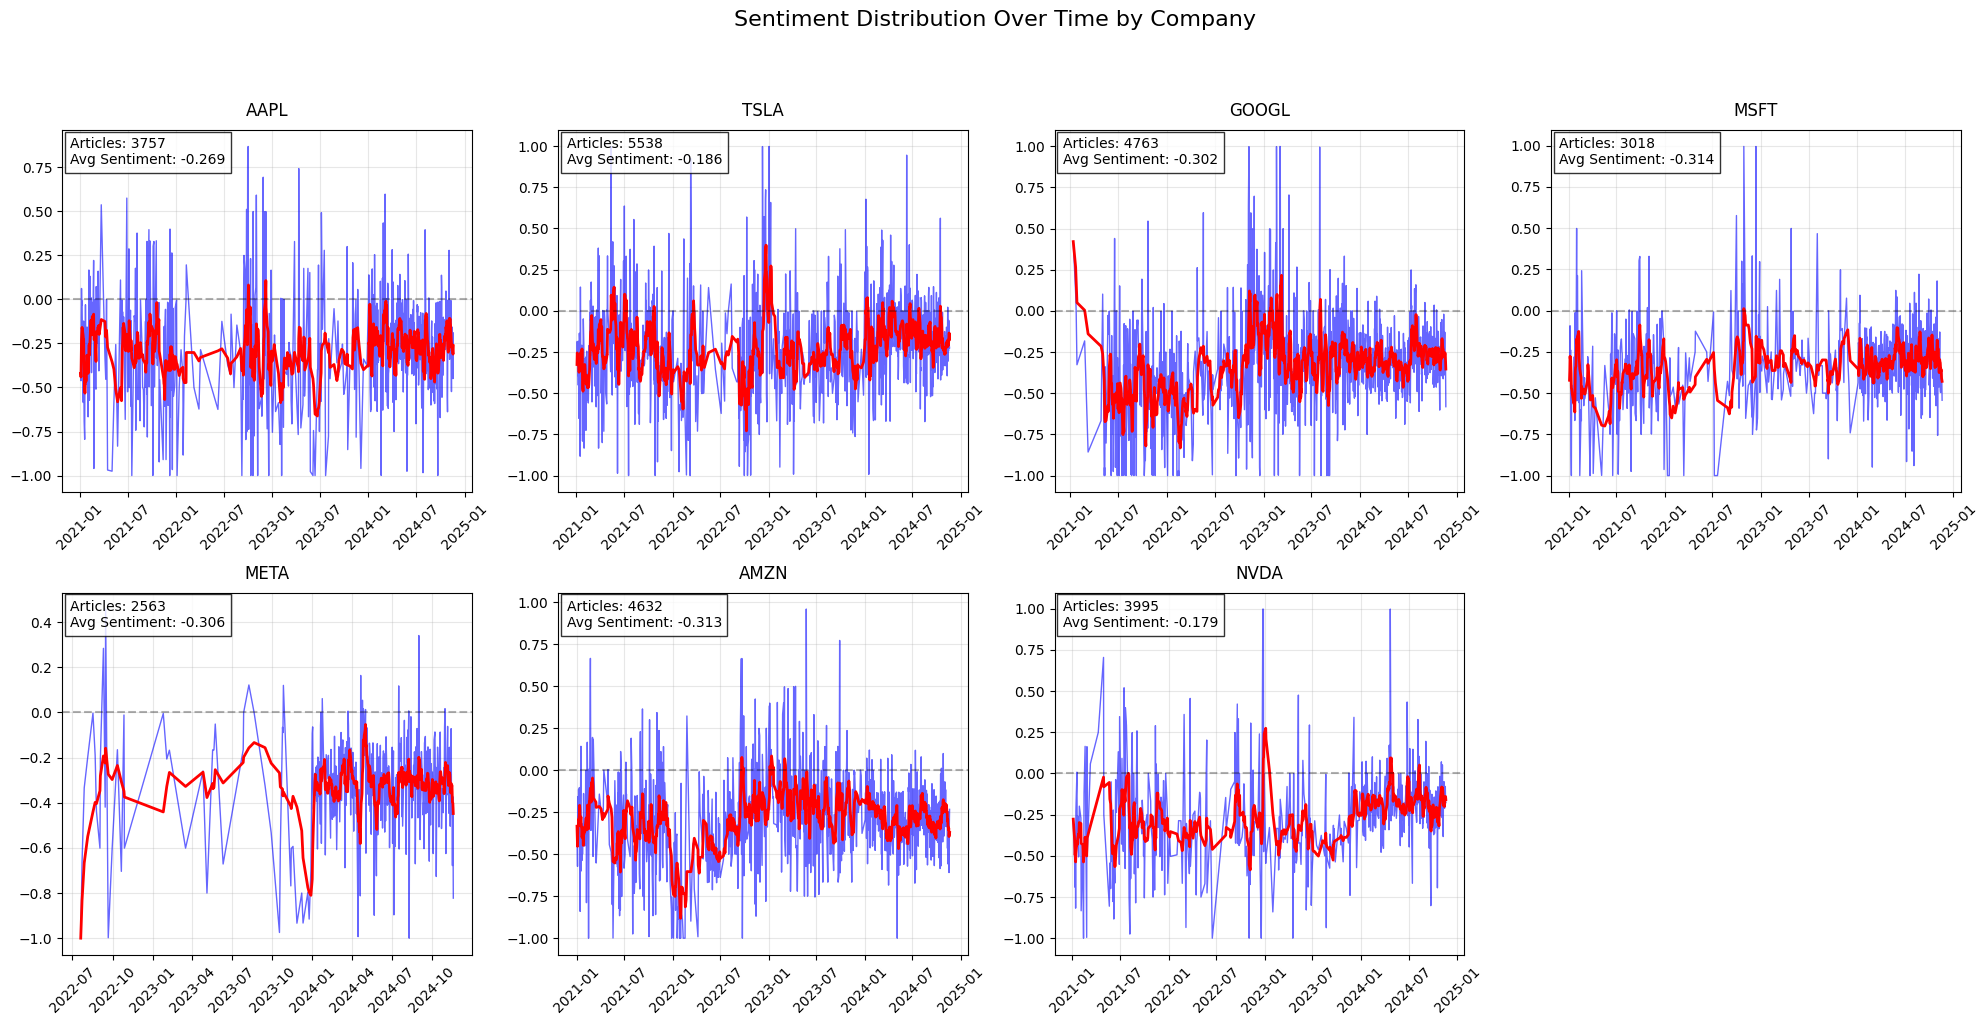


Summary Statistics by Company:

AAPL:
Total articles: 3757
count    3757.000
mean       -0.269
std         0.445
min        -1.000
25%        -0.579
50%        -0.248
75%        -0.000
max         0.998
Name: sentiment_score, dtype: float64

TSLA:
Total articles: 5538
count    5538.000
mean       -0.186
std         0.468
min        -1.000
25%        -0.500
50%        -0.181
75%         0.073
max         0.998
Name: sentiment_score, dtype: float64

GOOGL:
Total articles: 4763
count    4763.000
mean       -0.302
std         0.406
min        -1.000
25%        -0.556
50%        -0.286
75%        -0.039
max         0.998
Name: sentiment_score, dtype: float64

MSFT:
Total articles: 3018
count    3018.000
mean       -0.314
std         0.403
min        -1.000
25%        -0.558
50%        -0.293
75%        -0.071
max         0.998
Name: sentiment_score, dtype: float64

META:
Total articles: 2563
count    2563.000
mean       -0.306
std         0.397
min        -1.000
25%        -0.596
50%      

In [6]:
companies = ['AAPL', 'TSLA', 'GOOGL', 'MSFT', 'META', 'AMZN', 'NVDA']

# Time series plot for each company
plt.figure(figsize=(20, 10))

# Create subplots for each company (2 rows, 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Add title with padding
fig.suptitle('Sentiment Distribution Over Time by Company', 
             fontsize=16, y=1.02)  # Moved title up

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot for each company
for idx, company in enumerate(companies):
    company_data = news_df[news_df['stock'] == company].copy()
    
    # Calculate daily average sentiment
    company_data['Date'] = company_data['timestamp'].dt.date
    daily_sentiment = company_data.groupby('Date')['sentiment_score'].agg(['mean', 'count']).reset_index()
    
    # Create the plot
    ax = axes[idx]
    
    # Plot sentiment scores
    ax.plot(daily_sentiment['Date'], daily_sentiment['mean'], 
            color='blue', alpha=0.6, linewidth=1)
    
    # Add 7-day moving average
    rolling_mean = daily_sentiment['mean'].rolling(window=7, min_periods=1).mean()
    ax.plot(daily_sentiment['Date'], rolling_mean, 
            color='red', linewidth=2, label='7-day moving average')
    
    # Customize the plot
    ax.set_title(f'{company}', fontsize=12, pad=10)
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Add article count as text
    total_articles = len(company_data)
    avg_sentiment = company_data['sentiment_score'].mean()
    ax.text(0.02, 0.98, f'Articles: {total_articles}\nAvg Sentiment: {avg_sentiment:.3f}', 
            transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

# Remove the last subplot (since we have 7 companies and 8 spots)
axes[-1].remove()

# Adjust layout with extra space for title
plt.tight_layout()
fig.subplots_adjust(top=0.9)  # Make room for title

# savefig
plt.savefig('Figures/sentiment_over_time.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Print summary statistics
print("\nSummary Statistics by Company:")
print("=" * 80)
for company in companies:
    company_data = news_df[news_df['stock'] == company]
    stats = company_data['sentiment_score'].describe().round(3)
    print(f"\n{company}:")
    print(f"Total articles: {len(company_data)}")
    print(stats)

### 6.2 Summary Statistics

#### 6.2.1 Sentiment over time (lines charts)

Here, we generate boxplots and histograms to compare the sentiment score distributions across news articles and Reddit posts for each stock.

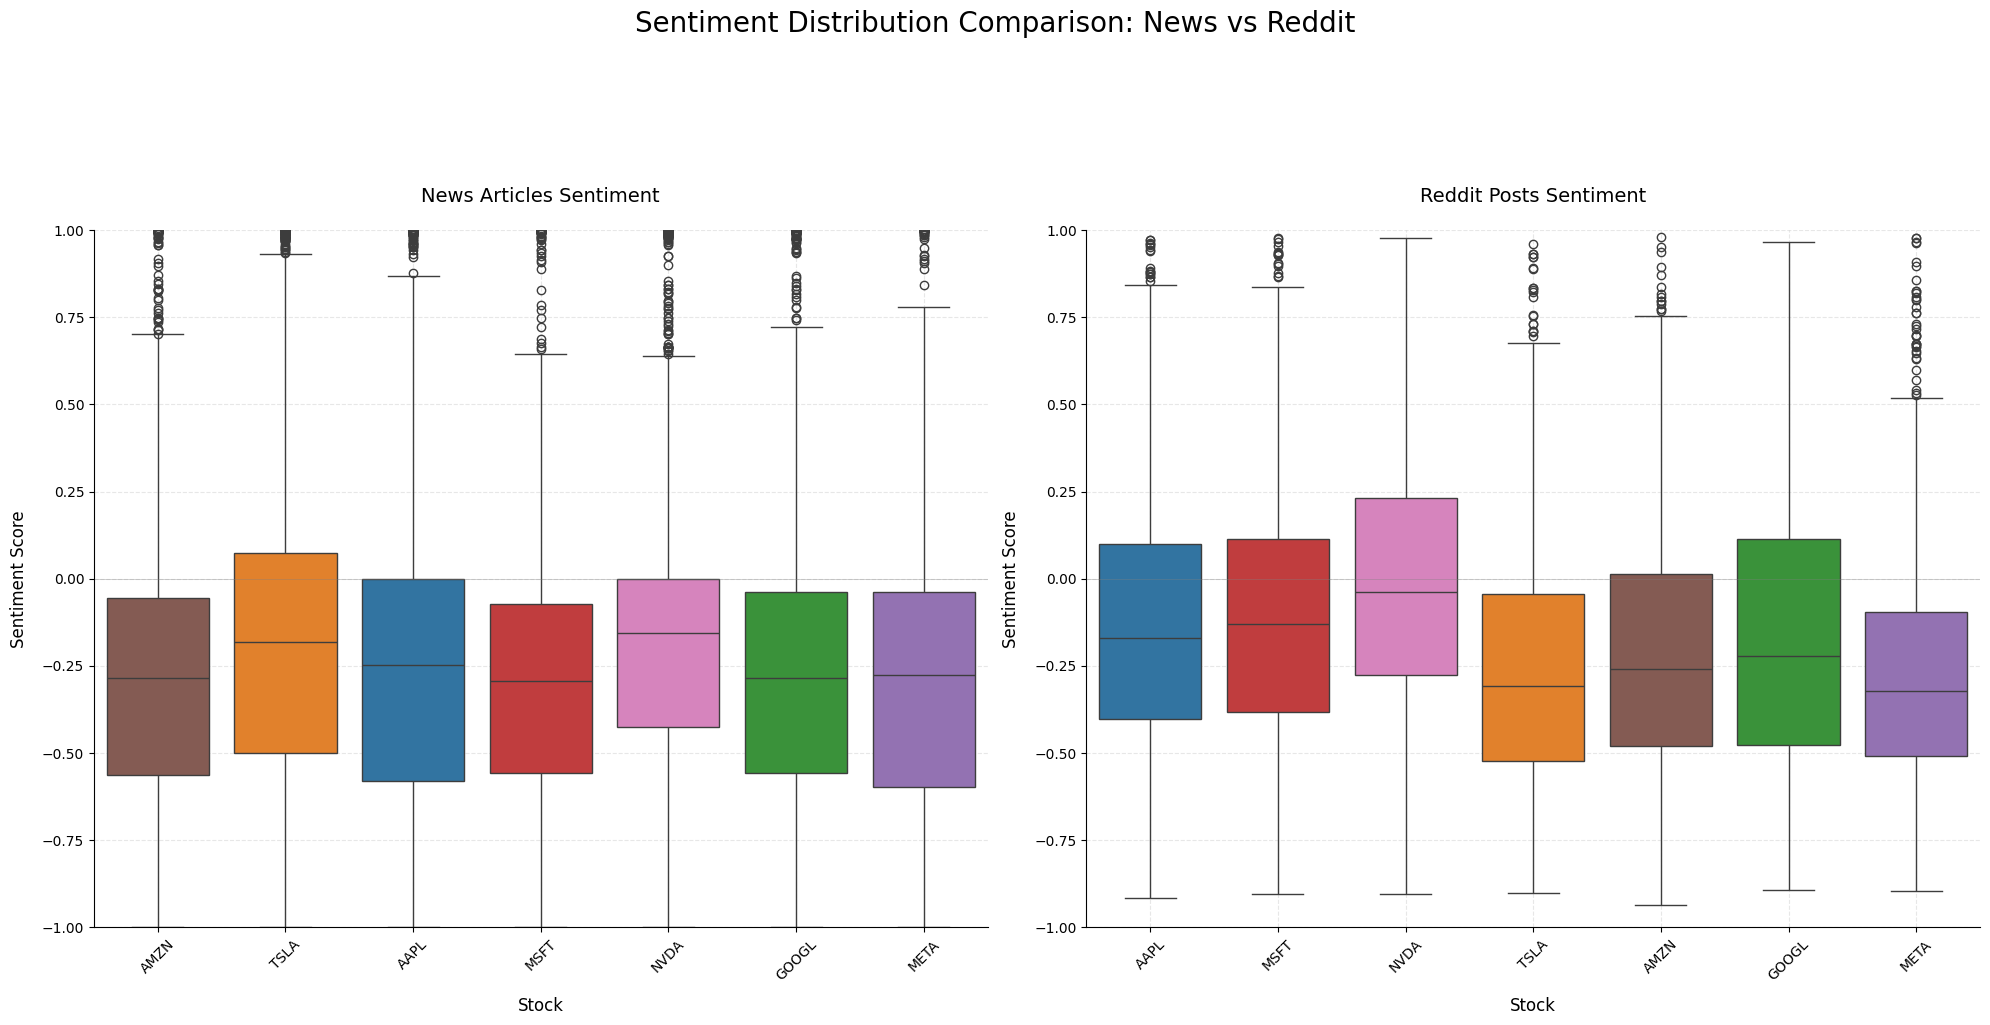

In [13]:
# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Define consistent color palette
colors = {
    'AAPL': '#1f77b4',  # blue
    'TSLA': '#ff7f0e',  # orange  
    'GOOGL': '#2ca02c', # green
    'MSFT': '#d62728',  # red
    'META': '#9467bd',  # purple
    'AMZN': '#8c564b',  # brown
    'NVDA': '#e377c2'   # pink
}

# Create color palette for seaborn
palette = [colors[company] for company in companies]

# Clean news data
news_df['stock'] = news_df['stock'].str.strip("[]'").str.replace("'", "")
news_df_single_stocks = news_df[news_df['stock'].isin(companies)]

# Plot 1: News Sentiment
sns.boxplot(data=news_df_single_stocks, 
            x='stock',  # Corrected column name
            y='sentiment_score',
            hue='stock',  # Corrected column name
            palette=colors,
            ax=ax1)

# Plot 2: Reddit Sentiment
sns.boxplot(data=reddit_df,
            x='stock',
            y='sentiment_score',
            hue='stock',  # Add hue parameter
            palette=colors,
            ax=ax2)

# Style the plots
for ax, title in zip([ax1, ax2], ['News Articles Sentiment', 'Reddit Posts Sentiment']):
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel('Stock', fontsize=12, labelpad=10)  # Corrected label name
    ax.set_ylabel('Sentiment Score', fontsize=12, labelpad=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Set y-axis limits for consistency
    ax.set_ylim(-1.0, 1.0)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add overall title
fig.suptitle('Sentiment Distribution Comparison: News vs Reddit', fontsize=20, y=1.02)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Make room for title

plt.savefig('Figures/boxplot_sentiment_comparison.jpg', dpi=300, bbox_inches='tight')
plt.show()


#### 6.2.2 Histograms & Stats of overall news sentiment

We compute summary statistics, including mean, standard deviation, and median sentiment scores for news and Reddit data, providing an overall sentiment overview.

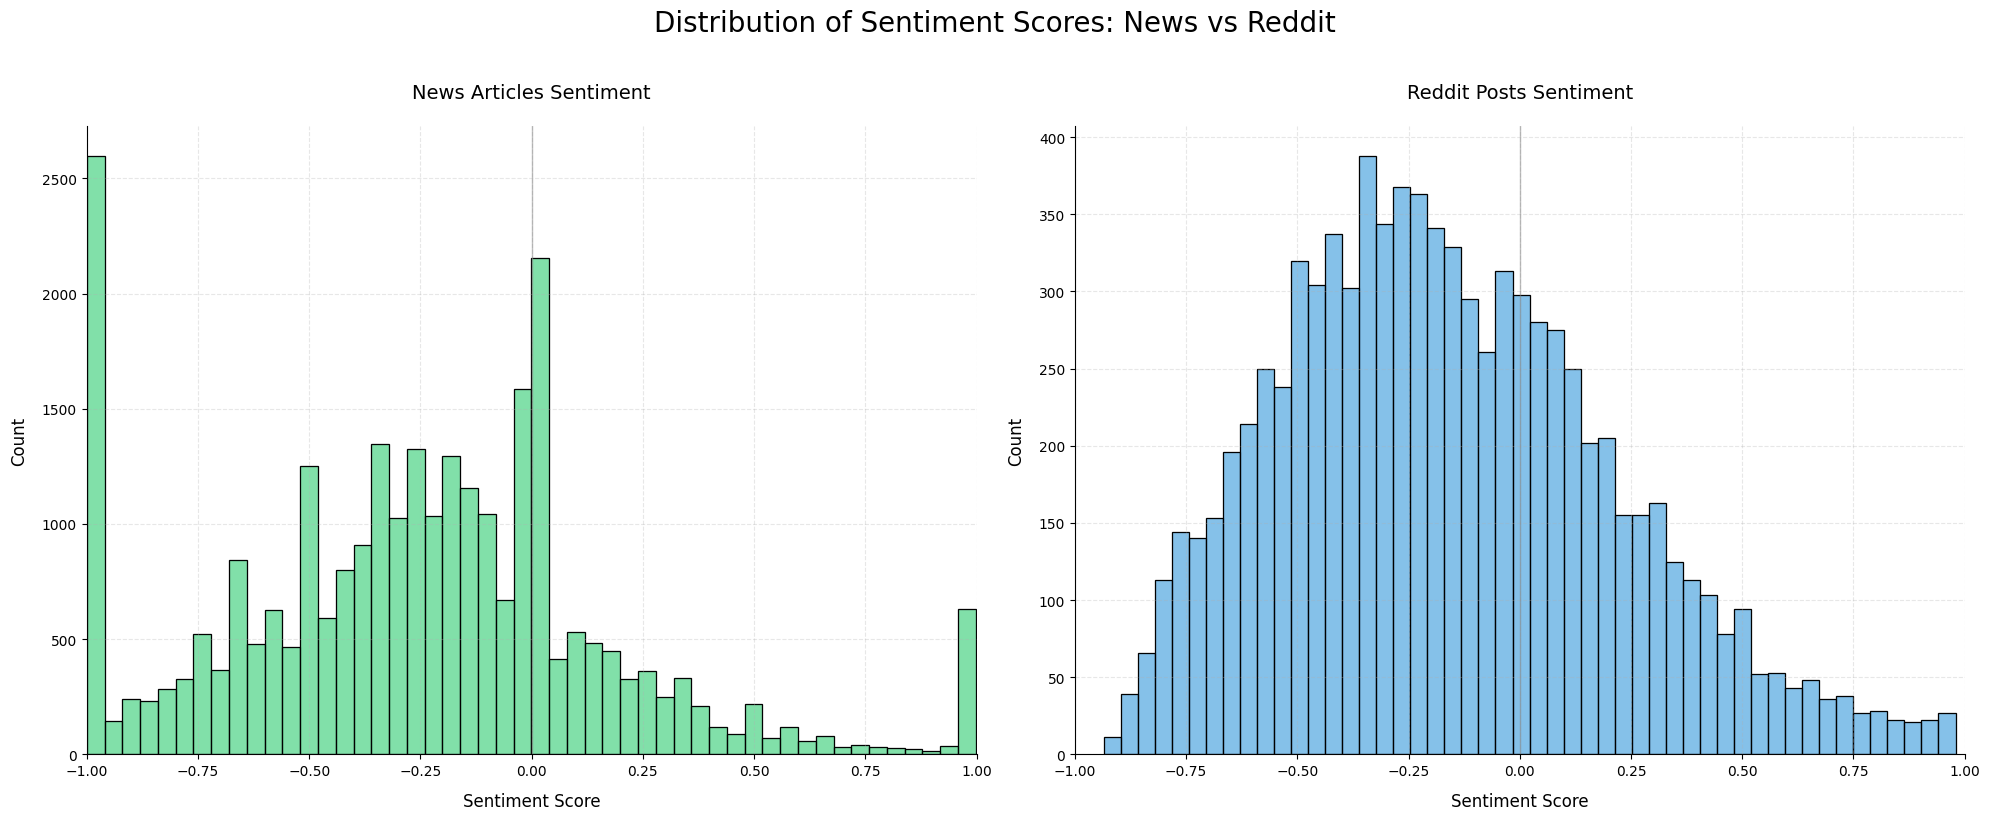


News Sentiment Score Summary Statistics:
count    28266.000
mean        -0.261
std          0.430
min         -1.000
25%         -0.526
50%         -0.250
75%         -0.001
max          0.998
Name: sentiment_score, dtype: float64

Reddit Sentiment Score Summary Statistics:
count    8742.000
mean       -0.161
std         0.374
min        -0.935
25%        -0.438
50%        -0.197
75%         0.083
max         0.979
Name: sentiment_score, dtype: float64

Skewness and Kurtosis:
News Skewness: 0.354
News Kurtosis: 0.475
Reddit Skewness: 0.465
Reddit Kurtosis: -0.133


In [14]:
import seaborn as sns

# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: News Sentiment Distribution
sns.histplot(data=news_df, 
            x='sentiment_score', 
            bins=50,
            color='#2ecc71',  # Green color
            alpha=0.6,
            ax=ax1)

# Plot 2: Reddit Sentiment Distribution
sns.histplot(data=reddit_df,
            x='sentiment_score',
            bins=50, 
            color='#3498db',  # Blue color
            alpha=0.6,
            ax=ax2)

# Style the plots
for ax, title in zip([ax1, ax2], ['News Articles Sentiment', 'Reddit Posts Sentiment']):
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel('Sentiment Score', fontsize=12, labelpad=10)
    ax.set_ylabel('Count', fontsize=12, labelpad=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Set consistent x-axis limits
    ax.set_xlim(-1.0, 1.0)

# Add overall title
fig.suptitle('Distribution of Sentiment Scores: News vs Reddit', fontsize=20, y=1.02)
plt.subplots_adjust(top=0.8)  # Make room for title

# Adjust layout
plt.tight_layout()

plt.savefig('Figures/sentiment_distribution_news_vs_reddit.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Print summary statistics
print("\nNews Sentiment Score Summary Statistics:")
print("=" * 80)
print(news_df['sentiment_score'].describe().round(3))

print("\nReddit Sentiment Score Summary Statistics:")
print("=" * 80)
print(reddit_df['sentiment_score'].describe().round(3))

# Additional statistics
print("\nSkewness and Kurtosis:")
print("=" * 80)
print(f"News Skewness: {news_df['sentiment_score'].skew():.3f}")
print(f"News Kurtosis: {news_df['sentiment_score'].kurtosis():.3f}")
print(f"Reddit Skewness: {reddit_df['sentiment_score'].skew():.3f}")
print(f"Reddit Kurtosis: {reddit_df['sentiment_score'].kurtosis():.3f}")

#### Barplots and Data Table for 24-Hour Sentiment Fluctuations

This code analyzes hourly sentiment trends for both news articles and Reddit posts, revealing peak activity times and sentiment variability within a day.

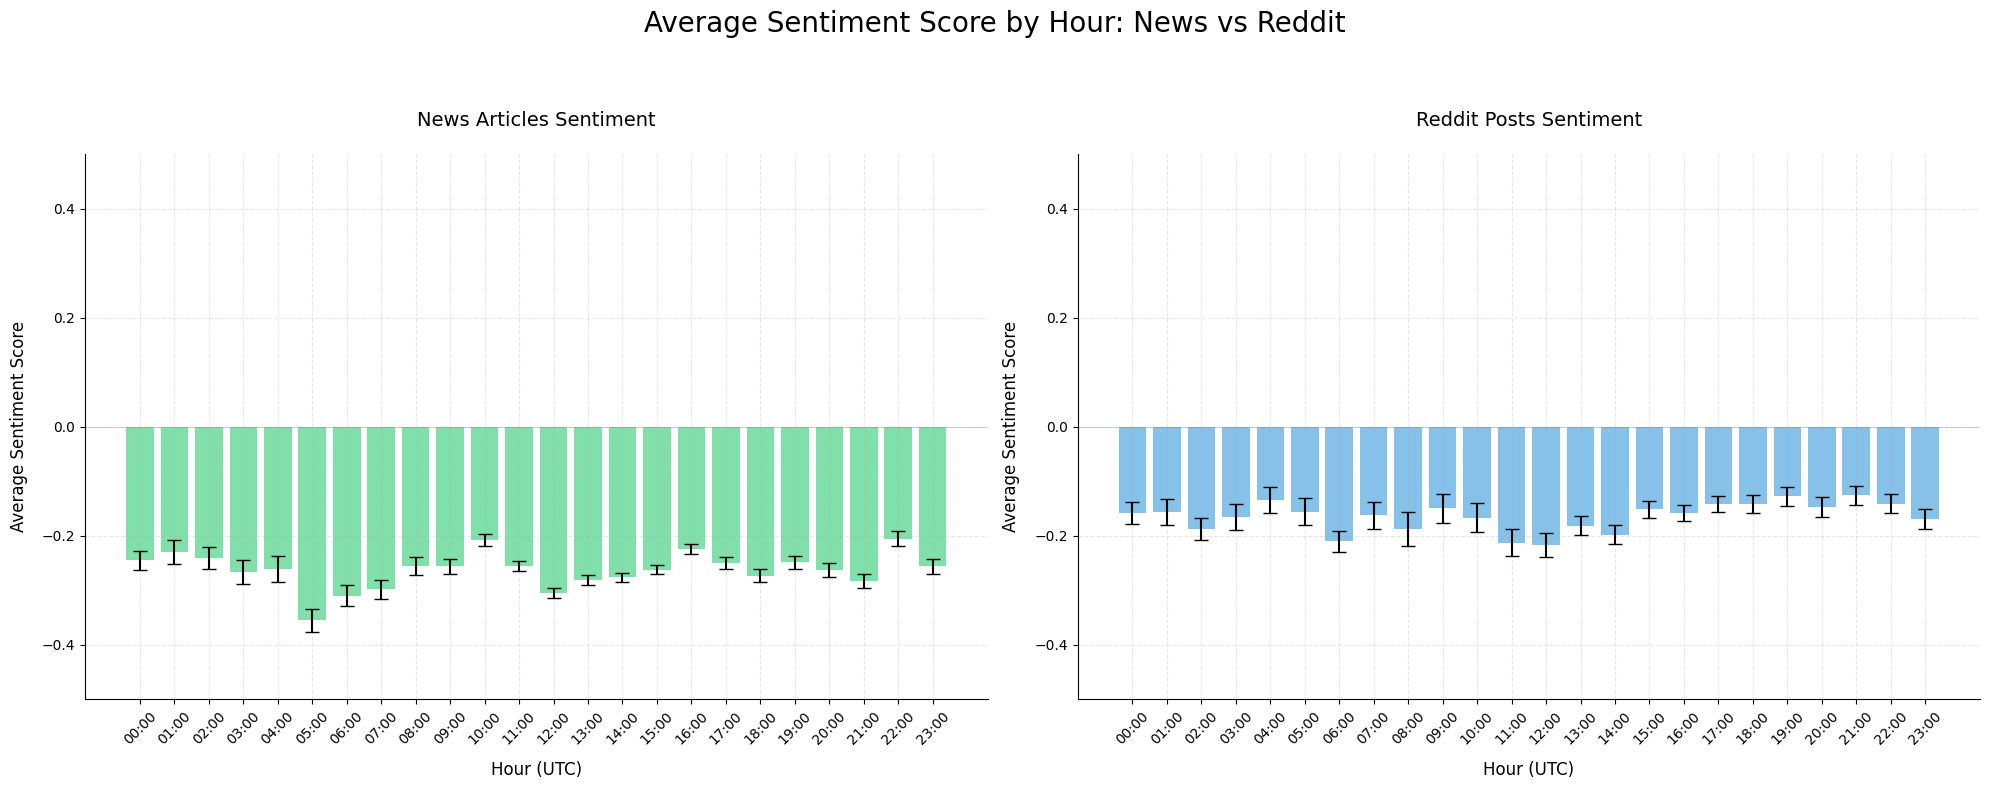

News Statistics Table:
\begin{table}[h!]
\centering
\caption{Hourly News Sentiment Statistics}
\label{tab:news_stats}
\begin{tabular}{lrrr}
\hline
Hour & Mean & Count & Std. Dev. \\
\hline
22:00 & -0.206 & 1287 & 0.510 \\
10:00 & -0.208 & 1254 & 0.415 \\
16:00 & -0.224 & 1995 & 0.428 \\
01:00 & -0.230 & 445 & 0.453 \\
02:00 & -0.241 & 452 & 0.428 \\
00:00 & -0.245 & 562 & 0.414 \\
19:00 & -0.248 & 1402 & 0.440 \\
17:00 & -0.250 & 1713 & 0.448 \\
11:00 & -0.255 & 1883 & 0.407 \\
08:00 & -0.256 & 687 & 0.438 \\
09:00 & -0.256 & 896 & 0.417 \\
23:00 & -0.256 & 1016 & 0.421 \\
04:00 & -0.261 & 382 & 0.472 \\
15:00 & -0.263 & 2277 & 0.394 \\
20:00 & -0.263 & 1228 & 0.426 \\
03:00 & -0.266 & 368 & 0.425 \\
18:00 & -0.273 & 1526 & 0.461 \\
14:00 & -0.277 & 2288 & 0.416 \\
13:00 & -0.281 & 2036 & 0.411 \\
21:00 & -0.283 & 1150 & 0.443 \\
07:00 & -0.298 & 601 & 0.438 \\
12:00 & -0.306 & 1836 & 0.402 \\
06:00 & -0.310 & 517 & 0.440 \\
05:00 & -0.355 & 465 & 0.449 \\
\hline
\end{tabular}
\end{tab

In [16]:
# Create figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Prepare news data
news_df['Hour'] = pd.to_datetime(news_df['timestamp']).dt.hour
news_hourly = news_df.groupby('Hour')['sentiment_score'].agg(['mean', 'count', 'std']).reset_index()

# Prepare Reddit data
reddit_df['Hour'] = pd.to_datetime(reddit_df['timestamp']).dt.hour
reddit_hourly = reddit_df.groupby('Hour')['sentiment_score'].agg(['mean', 'count', 'std']).reset_index()

# Plot 1: News Sentiment by Hour
ax1.bar(news_hourly['Hour'], 
        news_hourly['mean'],
        color='#2ecc71',
        alpha=0.6,
        yerr=news_hourly['std']/np.sqrt(news_hourly['count']),
        capsize=5)

# Plot 2: Reddit Sentiment by Hour
ax2.bar(reddit_hourly['Hour'],
        reddit_hourly['mean'],
        color='#3498db',
        alpha=0.6,
        yerr=reddit_hourly['std']/np.sqrt(reddit_hourly['count']),
        capsize=5)

# Style the plots
for ax, title in zip([ax1, ax2], ['News Articles Sentiment', 'Reddit Posts Sentiment']):
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel('Hour (UTC)', fontsize=12, labelpad=10)
    ax.set_ylabel('Average Sentiment Score', fontsize=12, labelpad=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Set x-axis ticks
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{i:02d}:00' for i in range(24)], rotation=45)
    
    # Set consistent y-axis limits
    ax.set_ylim(-0.5, 0.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add overall title
fig.suptitle('Average Sentiment Score by Hour: News vs Reddit', fontsize=20)

# Adjust layout with specific parameters
plt.tight_layout()
plt.subplots_adjust(top=0.8)  # Make room for title

# Save the figure
plt.savefig('Figures/hourly_sentiment_news_reddit.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics in LaTeX format
def create_latex_table(df, caption, label):
    latex_table = (
        f"\\begin{{table}}[h!]\n"
        f"\\centering\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        f"\\begin{{tabular}}{{lrrr}}\n"
        f"\\hline\n"
        f"Hour & Mean & Count & Std. Dev. \\\\\n"
        f"\\hline\n"
    )
    
    for _, row in df.iterrows():
        latex_table += f"{int(row['Hour']):02d}:00 & {row['mean']:.3f} & {int(row['count']):d} & {row['std']:.3f} \\\\\n"
    
    latex_table += (
        f"\\hline\n"
        f"\\end{{tabular}}\n"
        f"\\end{{table}}\n"
    )
    return latex_table

# Create LaTeX tables
news_latex = create_latex_table(
    news_hourly.sort_values('mean', ascending=False),
    "Hourly News Sentiment Statistics",
    "tab:news_stats"
)

reddit_latex = create_latex_table(
    reddit_hourly.sort_values('mean', ascending=False),
    "Hourly Reddit Sentiment Statistics",
    "tab:reddit_stats"
)

# Create peak hours table
peak_hours_latex = (
    "\\begin{table}[h!]\n"
    "\\centering\n"
    "\\caption{Peak Sentiment Hours}\n"
    "\\label{tab:peak_hours}\n"
    "\\begin{tabular}{lrr}\n"
    "\\hline\n"
    "Category & Hour & Score \\\\\n"
    "\\hline\n"
    f"News Most Positive & {news_hourly.loc[news_hourly['mean'].idxmax(), 'Hour']:02d}:00 & {news_hourly['mean'].max():.3f} \\\\\n"
    f"News Most Negative & {news_hourly.loc[news_hourly['mean'].idxmin(), 'Hour']:02d}:00 & {news_hourly['mean'].min():.3f} \\\\\n"
    f"Reddit Most Positive & {reddit_hourly.loc[reddit_hourly['mean'].idxmax(), 'Hour']:02d}:00 & {reddit_hourly['mean'].max():.3f} \\\\\n"
    f"Reddit Most Negative & {reddit_hourly.loc[reddit_hourly['mean'].idxmin(), 'Hour']:02d}:00 & {reddit_hourly['mean'].min():.3f} \\\\\n"
    "\\hline\n"
    "\\end{tabular}\n"
    "\\end{table}\n"
)

# Print the LaTeX tables
print("News Statistics Table:")
print("=" * 80)
print(news_latex)
print("\nReddit Statistics Table:")
print("=" * 80)
print(reddit_latex)
print("\nPeak Hours Table:")
print("=" * 80)
print(peak_hours_latex)

## 7. Stock Price Analysis (Gradients)

This section bridges sentiment data to stock performance by analyzing price movements. Gradients, moving averages, and visualizations help identify correlations between sentiment and stock trends

We analyze stock price movements using:
- Intraday price data (open and close)
- Price trend visualization
- Moving averages


#### 7.1 Stock Price Cleaning & Merging

This code cleans and preprocesses stock price data, ensuring proper formatting and alignment of intraday open and close prices for analysis.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Read the CSV files
stocks_close = pd.read_csv(r"Data\StockData\Googlefinance_stocks - Close_values.csv", skiprows=1)
stocks_open = pd.read_csv(r"Data\StockData\Googlefinance_stocks - Open_values.csv", skiprows=1)

# Clean up column names - remove empty columns
stocks_close = stocks_close.iloc[:, [0,1,3,5,7,9,11,13]]  # Select only the non-empty columns
stocks_open = stocks_open.iloc[:, [0,1,3,5,7,9,11,13]]

# Rename columns
column_names = ['Date', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'GOOGL', 'META']
stocks_close.columns = column_names
stocks_open.columns = column_names

# Convert price columns to float (replacing commas with dots)
for col in column_names[1:]:  # Skip the Date column
    stocks_close[col] = stocks_close[col].str.replace(',', '.').astype(float)
    stocks_open[col] = stocks_open[col].str.replace(',', '.').astype(float)

# First replace the time format in the date strings
stocks_close['Date'] = stocks_close['Date'].str.replace('.', ':')
stocks_open['Date'] = stocks_open['Date'].str.replace('.', ':')

# Change open dates to 9:30:00
stocks_open['Date'] = stocks_open['Date'].str[:-8] + "09:30:00"

# Convert dates to datetime
stocks_close['Date'] = pd.to_datetime(stocks_close['Date'], format='%d/%m/%Y %H:%M:%S')
stocks_open['Date'] = pd.to_datetime(stocks_open['Date'], format='%d/%m/%Y %H:%M:%S')

# Sort by date
stocks_close = stocks_close.sort_values('Date')
stocks_open = stocks_open.sort_values('Date')

# Reset indices after sorting
stocks_close.reset_index(drop=True, inplace=True)
stocks_open.reset_index(drop=True, inplace=True)

# Combine open and close data
all_stocks = pd.concat([stocks_open, stocks_close]).sort_values(by='Date').reset_index(drop=True)

all_stocks_long = all_stocks.melt(id_vars='Date', var_name='Stock', value_name='Price')

#### 7.2 Stock Price Visualization

This code generates line plots showing stock price trends over time, enabling a visual comparison of price changes for multiple companies

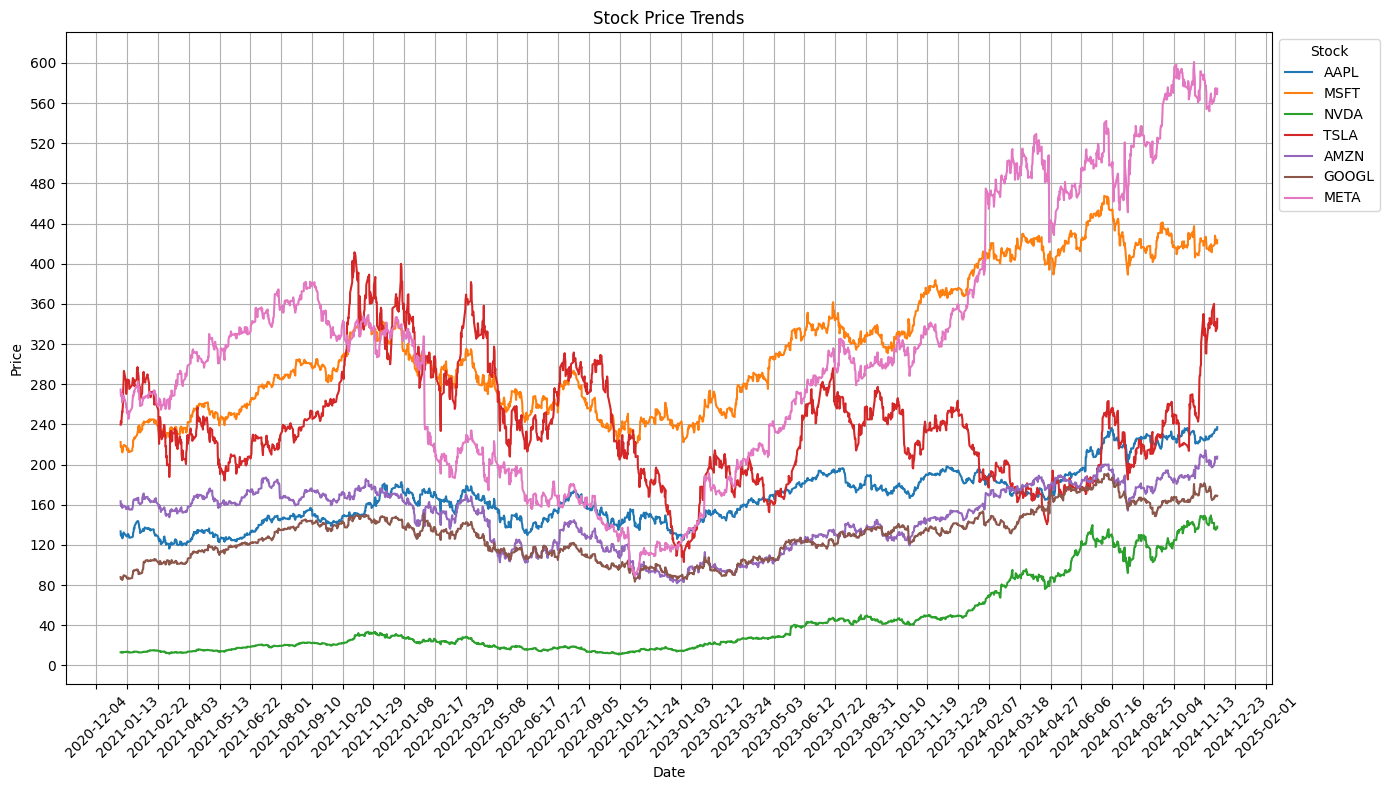

In [18]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=all_stocks_long, x='Date', y='Price', hue='Stock')
plt.title('Stock Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend(title='Stock', bbox_to_anchor=(1.00, 1), loc='upper left')
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))  # Increase the number of x-axis ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=20))  # Increase the number of y-axis ticks

plt.tight_layout()
plt.show()

#### 7.3 Average Gradient Calculation

This function computes the average price gradients before and after a specific time point, helping to measure the rate of price change around significant events.

In [19]:
def average_gradient(df, stock, date_time, t):
    """
    Calculate the average gradient for a given stock around a specified date and time.
    
    Parameters:
    - df (DataFrame): The dataframe containing Date, stock prices as columns.
    - stock (str): The stock symbol for which to calculate the gradient (e.g., 'AAPL').
    - date_time (str or datetime): The reference date and time as a string or datetime object.
    - t (int): Number of timesteps before and after the date_time to calculate the gradient.
    
    Returns:
    - float: The average gradient (price change per timestep).
    """
    # Ensure date_time is in datetime format
    date_time = pd.to_datetime(date_time)
    
    # Determine indices for `t` steps before and `t` steps after, even if `date_time` is not in the data
    before_indices = df.index[df['Date'] <= date_time].to_numpy()[-(t[0]+1):]  # Last `t` steps before or equal
    after_indices = df.index[df['Date'] > date_time].to_numpy()[:t[1]]      # First `t` steps after
    
    print(after_indices, before_indices)
    after_indices = np.sort(np.append(after_indices, before_indices[-1]))
    print(after_indices)

    before_prices = df.loc[before_indices, stock].to_numpy()
    avg_gradient_before = np.gradient(before_prices).mean()

    after_prices = df.loc[after_indices, stock]
    avg_gradient_after = np.gradient(after_prices).mean()

    return avg_gradient_before, avg_gradient_after

before, after = average_gradient(all_stocks, 'TSLA', '2023-06-02 13:30:00', (1,1))

[1215] [1213 1214]
[1214 1215]


## 8. Locality Sensitivity Hashing & Clustering

Clustering techniques help reveal underlying patterns in sentiment and market data. This section employs Locality Sensitivity Hashing (LSH) and Louvain partitioning for community detection.

### 8.1. Preprocessing, Duplicate Detection, and construction of LSH indices

This code merges, preprocesses, and builds LSH indices to identify near-duplicate news articles or posts, reducing redundancy in the dataset - Firstly a class is implemented to process a dataframe of documents.

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
from collections import Counter
import networkx as nx
from datasketch import MinHash, MinHashLSH, LeanMinHash
# Import stopwords from NLTK
from nltk.corpus import stopwords
from tqdm import tqdm
from random import seed, randint
import ast
from networkx.algorithms.community import louvain_communities, modularity

np.random.seed(42)
seed(42)
# Download stopwords and punkt tokenizer from NLTK

import nltk
nltk.download('stopwords')


class NewsData:
    def __init__(self, df: pd.DataFrame):
        """Handles news article dataframes."""
        self.df = df  # Drop rows with missing body text
        self.df["cleaned"] = self.df["body"].apply(self.clean_text)  # Clean text column
        self.df["timestamp"] = self.df["timestamp"].apply(self.convert_date)  # Convert date column to datetime

    def clean_text(self, text):
        """Standardizes and cleans text by lowercasing, removing punctuation, and extra whitespace."""
        try:
             text = text.lower()  # Lowercasing
             text = re.sub(r'(?:https?://|www\.)[^\s]+|(?:\b[a-zA-Z0-9.-]+\.(?:com|org|net|io)\b)', '', text)
             text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
             text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # Remove special characters such as /, \, |, # etc.
             text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
        except:
            print(text)
            # print row number
            print(self.df[self.df['body'] == text].index)
            # print row
            print(self.df[self.df['body'] == text])

        # Remove stopwords and words "one", "time", "reddit"
        stop_words = set(stopwords.words('english')).union({"one", "reddit", "time", "zacks", "rank", "motley", "fool", "cookies",
                                                            "terms", "service", "privacy", "policy", "contact", "us", "advertising",
                                                            "about", "careers", "help", "site", "map", "copyright", "trademark",
                                                            "disclaimer", "accessibility", "preferences", "newsletter", "feedback",
                                                            "use", "site", "constitutes", "acceptance", "user", "agreement", "please",
                                                            "password", "forgot", "username", "email", "email", "password", "username",
                                                            "dont", "know", "company", "return", "stock", "market", "investment",
                                                            "herein", "represented", "said"})
        text = " ".join([word for word in text.split() if word not in stop_words])
        return text
    
    def generate_minhash(self, doc, num_perm=256):
        """Generates a MinHash signature for a document."""
        minhash = MinHash(num_perm=num_perm)
        for word in set(doc.split()):  # Use set to avoid duplicate contributions
            minhash.update(word.encode('utf8'))
        return LeanMinHash(minhash)
    
    def delete_lsh(self):
        """Deletes the LSH index to free up memory."""
        del self.lsh
        del self.minhashes
    
    def build_lsh(self, threshold=0.2, num_perm=128):
        """Builds an LSH index for approximate similarity detection."""
        self.lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
        self.minhashes = {}  # Store MinHash objects for later use

        # TQDM this
        for idx, doc in enumerate(tqdm(self.df["cleaned"], desc="Building LSH index")):
            minhash = self.generate_minhash(doc, num_perm=num_perm)
            self.lsh.insert(idx, minhash)  # Insert into LSH
            self.minhashes[idx] = minhash  # Cache for querying
    
    def find_duplicates(self):
        """Finds clusters of near-duplicate documents."""
        duplicate_groups = []
        visited = set()

        for idx in self.minhashes:
            if idx in visited:
                continue
            group = self.lsh.query(self.minhashes[idx])  # Find similar documents
            duplicate_groups.append(group)
            visited.update(group)

        return duplicate_groups
    
    def merge_duplicates(self, duplicate_groups):
        """Merges near-duplicate documents into single nodes."""
        # Create a mapping from original document indices to merged node indices
        merged_mapping = {}
        keep_indices = set()
        remove_indices = set()
        
        for node_idx, group in enumerate(duplicate_groups):
            # Map each document index in the group to the representative node index
            merged_mapping.update({doc_idx: node_idx for doc_idx in group})
            
            # Keep the first document in the group and mark the rest for removal
            keep_indices.add(group[0])
            remove_indices.update(group[1:])

        # Remove duplicates from the DataFrame, keeping only representative rows
        self.df = self.df.drop(index=list(remove_indices)).reset_index(drop=True)
        
        # Update merged_mapping to account for new DataFrame indices
        updated_mapping = {}
        for old_idx, new_idx in enumerate(self.df.index):
            if old_idx in merged_mapping:
                updated_mapping[new_idx] = merged_mapping[old_idx]
        
        self.merged_mapping = updated_mapping

    def build_vocabulary(self):
        """Creates a consistent vocabulary across documents."""
        vocabulary = set()
        for article in self.df["cleaned"]:
            vocabulary.update(article.split())
        return vocabulary

    def compute_similarity_lsh(self):
        """Uses LSH to find similar document pairs."""
        for idx in self.minhashes:
            similar_docs = self.lsh.query(self.minhashes[idx])
            for sim_idx in similar_docs:
                if idx < sim_idx:  # Avoid duplicate pairs
                    yield idx, sim_idx
 
    
    def convert_date(self, date_str):
        """Converts a date string to a datetime object."""

        return pd.to_datetime(date_str)

def calculate_modularity(graph, partitions):
    m = graph.size(weight="weight")  # Total weight of edges
    degrees = dict(graph.degree(weight="weight"))  # Degree of each node
    modularity_score = 0

    node_to_community = {node: idx for idx, partition in enumerate(partitions) for node in partition}

    # Compute modularity
    for u in graph.nodes():
        for v in graph.nodes():
            if u == v or not graph.has_edge(u, v):
                A_uv = 0  # No edge between u and v
            else:
                A_uv = graph[u][v].get("weight", 1)  # Edge weight
            k_u = degrees[u]
            k_v = degrees[v]
            expected_weight = (k_u * k_v) / (2 * m)
            if node_to_community[u] == node_to_community[v]:  # Same community
                modularity_score += (A_uv - expected_weight)

    modularity_score /= (2 * m)
    return modularity_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jbhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stock_data = r"Data\StockData\Stock_prices_2021_to_2024.csv"
reddit_data = r"Data\final\Reddit_2021_to_2024_with_sentiment.csv"
news_data = r"Data\final\cleaned_combined_news_with_bodies_with_sentiment.csv"
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "NVIDIA": "NVDA",
    "Nvidia": "NVDA",
    "Tesla": "TSLA",
    "Amazon": "AMZN",
    "Alphabet": "GOOGL",
    "Meta": "META",
    "Google": "GOOGL",
}

# Load the stock data
stock_df = pd.read_csv(stock_data)
print("Length of stock data: ", len(stock_df))
# Load the reddit data
reddit_df = pd.read_csv(reddit_data)
print("Length of reddit data: ", len(reddit_df))
# Load the news data
news_df = pd.read_csv(news_data)
print("Length of news data: ", len(news_df))

# Add the title and body columns together
reddit_df['body'] = reddit_df['title'] + ' ' + reddit_df['body']
reddit_df['stock'] = reddit_df['stock'].apply(lambda x: str([stock_dict[str(x)]]) if x in stock_dict else [str(x)])
# Rename column "source" to "Source"
reddit_df = reddit_df.rename(columns={"source": "Source"})

news_df['body'] = news_df['title'] + ' ' + news_df['body']


# Concat the reddit and news data
#news_df = pd.concat([reddit_df, news_df], ignore_index=True)

# Drop rows with NA values
reddit_df = reddit_df.dropna(subset=['body', 'title'])
news_df = news_df.dropna(subset=['body', 'title'])

reddit = NewsData(news_df) # Replace with reddit_df for only reddit data
# Do note the class name; here, it is still the news data - NOT reddit data despite the name of the variable

print("Created the NewsData object")

for i in range(len(reddit.df)):
    reddit.df.at[i, 'stock'] = ast.literal_eval(reddit.df.at[i, 'stock'])


# Step 1: Build LSH and find near-duplicates
print("Size before merge: ", len(reddit.df))
reddit.build_lsh(threshold=0.97)  # High threshold to detect near-duplicates
print("Built the LSH")
duplicate_groups = reddit.find_duplicates()
print("Found duplicates")

# Step 2: Merge near-duplicates
reddit.merge_duplicates(duplicate_groups)
print("Merged duplicates, size: ", len(reddit.df))

reddit.delete_lsh()


Length of stock data:  1468
Length of reddit data:  8742
Length of news data:  32242
Created the NewsData object
Size before merge:  32242


Building LSH index: 100%|██████████| 32242/32242 [02:03<00:00, 262.07it/s]


Built the LSH
Found duplicates
Merged duplicates, size:  31501


### 8.2 Building the LSH Graph and Partitioning Using Louvain

Constructs a similarity graph using Locality Sensitive Hashing (LSH) to connect nodes (documents) with high similarity based on a defined threshold - 0.42 for News data and 0.25 for Reddit data. The permutations used are 2048 for News data and 6114 for Reddit data. 

! This can take up towards 10 minutes if done without the pickle files.

In [22]:
from tqdm import tqdm
import os
import pickle

                    # Replace with reddit_graph.pickle and reddit_partition.pickle for only news data if downloaded
if os.path.exists("news_graph.pickle") and os.path.exists("news_partition.pickle"):
    with open("news_graph.pickle", "rb") as f:
        G = pickle.load(f)
    with open("news_partition.pickle", "rb") as f:
        partition = pickle.load(f)
    print("Loaded the graph and partition from files")
else:
    G = nx.Graph()
    num_docs = reddit.df.shape[0]
    total_comparisons = num_docs * (num_docs - 1) // 2

    reddit.build_lsh(threshold=0.42, num_perm=2048)  # Lower threshold for general similarity

    # Add edges to the graph based on similarity scores
    for i, j in tqdm(reddit.compute_similarity_lsh(), total=total_comparisons, desc="Building Graph"):
        G.add_edge(int(i), int(j))

    # Perform Louvain community detection

    partition = louvain_communities(G, resolution=1)

    # Print the community detection results
    print("\nLouvain Community Detection Result:")
    print(partition)

print("\nModularity:", modularity(G, partition))

Building Graph:   0%|          | 344042/496140750 [00:17<6:50:28, 20130.77it/s] 



Louvain Community Detection Result:
[{492, 7}, {9, 10}, {5123, 8197, 1292, 13, 5900, 7183, 3103, 6178, 551, 807, 2345, 3388, 2879, 3647, 10561, 324, 3405, 1358, 2637, 5203, 4950, 4184, 3674, 13403, 1115, 5980, 15968, 1635, 3683, 22629, 19306, 5743, 3443, 884, 3962, 2435, 643, 1419, 5518, 9361, 4502, 4765, 10143, 12960, 938, 3759, 14513, 6066, 2233, 445, 4029, 961, 1218, 4804, 3528, 1485, 3792, 4309, 15573, 15071, 3553, 2017, 1765, 12261, 5867, 12524, 12013, 6130, 6131, 245, 3833}, {546, 14}, {457, 890, 21}, {1280, 5002, 2892, 976, 3217, 978, 977, 980, 25, 1243, 931, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 1388, 3951, 1385, 1387, 1386, 1209}, {27, 893}, {28, 20047}, {22593, 47}, {49, 50}, {52, 1733}, {54, 867, 91, 27926}, {72, 82}, {1728, 98}, {13897, 99}, {100, 17186, 18955, 18532}, {128, 168}, {129, 3149}, {529, 834, 1332, 824, 137, 764}, {144, 143}, {146, 18978}, {165, 534}, {201, 202}, {207, 775}, {226, 1755, 3781}, {333, 238}, {489, 242, 535}, {257, 5537}, {259, 621}, {277

In [23]:
# Add the community to the dataframe
reddit.df['community'] = np.nan
for i, community in enumerate(partition):
    reddit.df.loc[list(community), 'community'] = int(i)

### 8.4 Visualizing full LSH-Partitioned

Visualizes the LSH graph by highlighting the largest communities that cover 75% of the nodes, removing smaller or less relevant clusters for clarity.

In [24]:
print("\nNumber of Communities:", len(partition))

# Make a list of distinct colors for the communities
colors = ["#"+''.join([randint(0, 255).to_bytes(1, 'big').hex() for _ in range(3)]) for _ in range(len(partition))]


Number of Communities: 1618


In [ ]:
import netwulf as nw
import matplotlib.pyplot as plt

# Assign nodes to their corresponding communities
node_to_community = {}
for community_index, community in enumerate(partition):
    for node in community:
        node_to_community[node] = community_index

# Add the community data to each node as an attribute
for node in G.nodes():
    G.nodes[node]['group'] = node_to_community[node]
    G.nodes[node]['color'] = colors[node_to_community[node]]

# Calculate community sizes
community_sizes = {i: len(community) for i, community in enumerate(partition)}

# Sort communities by size and retain the top 75% by size
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
cumulative_size = sum(size for _, size in sorted_communities)
threshold = 0.75 * cumulative_size  # Top 75% of total node coverage

# Find the largest communities that make up the top 75% of the size
selected_communities = set()
current_size = 0
for community_index, size in sorted_communities:
    if current_size + size > threshold:
        break
    selected_communities.add(community_index)
    current_size += size

# Copy graph and remove nodes from excluded communities
graph_to_plot = G.copy()
for node in list(graph_to_plot.nodes()):  # Convert to list to avoid runtime errors during iteration
    if node_to_community[node] not in selected_communities:
        graph_to_plot.remove_node(node)

print("Number of nodes:", graph_to_plot.number_of_nodes())

# Visualize the updated graph
nw.visualize(graph_to_plot, config={'zoom': 0.1, 'linkAlpha': 0.1, 'collisions': False})

### 8.5 Visualizing Aggregated LSH-Partitioned Graph

Creates and visualizes an aggregated graph where each node represents a community, with weighted edges summarizing connections between them.

In [ ]:
aggregate_graph = nx.Graph()

for node in graph_to_plot.nodes(data=True):
    comm_node = node[1]['group']
    if comm_node not in aggregate_graph.nodes:
        aggregate_graph.add_node(comm_node, radius=1, group=comm_node)
        aggregate_graph.nodes[comm_node]['color'] = colors[comm_node]
        # Add an edge to itself
        aggregate_graph.add_edge(comm_node, comm_node, weight=0)
    else:
        aggregate_graph.edges[comm_node, comm_node]['weight'] += 1


for n1, n2, data in graph_to_plot.edges(data=True):
    comm1 = G.nodes[n1]['group']
    comm2 = G.nodes[n2]['group']
    # If the edge exists in the original graph, add it to the aggregate graph
    if not aggregate_graph.has_edge(comm1, comm2):
        aggregate_graph.add_edge(comm1, comm2, weight=1)

print("Edges: ", aggregate_graph.edges(data=True))
print("Nodes: ", aggregate_graph.nodes(data=True))

nw.visualize(aggregate_graph, config={'zoom': 0.1, 'link_alpha':0.5, 'collisions': False, 'scale_node_size_by_strength': True, 'display_singleton_nodes': False,
                                      'link_width': 15, 'link_width_variation': 0.6, 'display_node_labels': True})
    

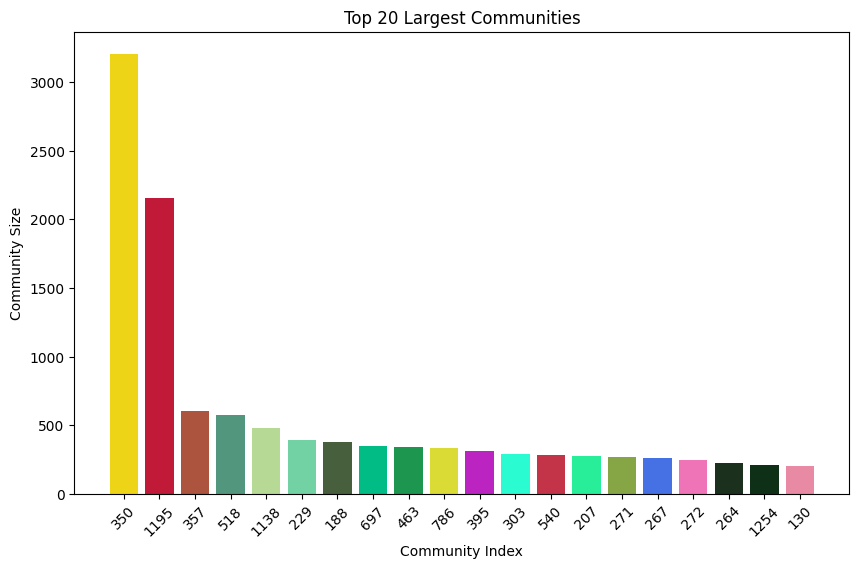

In [27]:
# Sort the community sizes in descending order and select the top 20
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)[:20]

# Extract indices and sizes of the top 20 communities
top_community_indices = [item[0] for item in sorted_communities]
top_community_sizes = [item[1] for item in sorted_communities]

# Map the colors to the community indices
top_colors = [colors[idx] for idx in top_community_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_community_sizes)), top_community_sizes, color=top_colors)
plt.xticks(range(len(top_community_indices)), top_community_indices, rotation=45)  # Label x-axis with community indices
plt.xlabel("Community Index")
plt.ylabel("Community Size")
plt.title("Top 20 Largest Communities")
plt.show()

### 8.6 Investigation of source distribution in clusters

Investigates the distribution of sources in the clusters, to see if the clusters are only formed around sources and not necessarily content
- This does not make sense to do with the Reddit data.

In [29]:
# Loop through each community index
source_counts = reddit.df['source'].value_counts()
total_dataset_size = len(reddit.df)

for community_index in top_community_indices:
    print(f"\nCommunity {community_index}:")
    
    # Subset for the current community
    community_data = reddit.df[reddit.df['community'] == community_index]
    
    # Size of the current cluster
    cluster_size = len(community_data)
    
    # Count of each source in the current cluster
    community_sources = Counter(community_data['source'])
    
    for source, cluster_source_count in community_sources.items():
        # Calculate the expected count for this source in the cluster
        expected_count = source_counts[source] * (cluster_size / total_dataset_size)
        
        # Calculate the ratio
        ratio = cluster_source_count / expected_count if expected_count > 0 else 0
        
        print(f"{source}: {cluster_source_count} (Ratio: {ratio:.2f})") 


Community 350:
investmentu.com: 1 (Ratio: 0.82)
forbes.com: 6 (Ratio: 1.23)
benzinga.com: 35 (Ratio: 0.08)
thegoodinvestors.sg: 1 (Ratio: 3.28)
insidermonkey.com: 3 (Ratio: 0.02)
financialpost.com: 2 (Ratio: 0.31)
finextra.com: 1 (Ratio: 9.83)
markets.businessinsider.com: 2 (Ratio: 0.06)
investopedia.com: 1 (Ratio: 0.16)
entrepreneur.com: 2 (Ratio: 0.53)
economictimes.indiatimes.com: 1 (Ratio: 0.38)
gurufocus.com: 1 (Ratio: 0.02)
finance.yahoo.com: 56 (Ratio: 0.40)
Yahoo: 3080 (Ratio: 1.72)
Finnhub: 8 (Ratio: 0.03)
SeekingAlpha: 6 (Ratio: 0.10)

Community 1195:
insidermonkey.com: 1299 (Ratio: 9.84)
benzinga.com: 13 (Ratio: 0.04)
forbes.com: 2 (Ratio: 0.61)
entrepreneur.com: 2 (Ratio: 0.79)
finance.yahoo.com: 11 (Ratio: 0.12)
Yahoo: 820 (Ratio: 0.68)
Finnhub: 2 (Ratio: 0.01)
gurufocus.com: 1 (Ratio: 0.02)
SeekingAlpha: 3 (Ratio: 0.08)

Community 357:
prnewswire.com: 1 (Ratio: 0.34)
forbes.com: 4 (Ratio: 4.32)
benzinga.com: 13 (Ratio: 0.16)
insidermonkey.com: 406 (Ratio: 10.91)
reddit.c

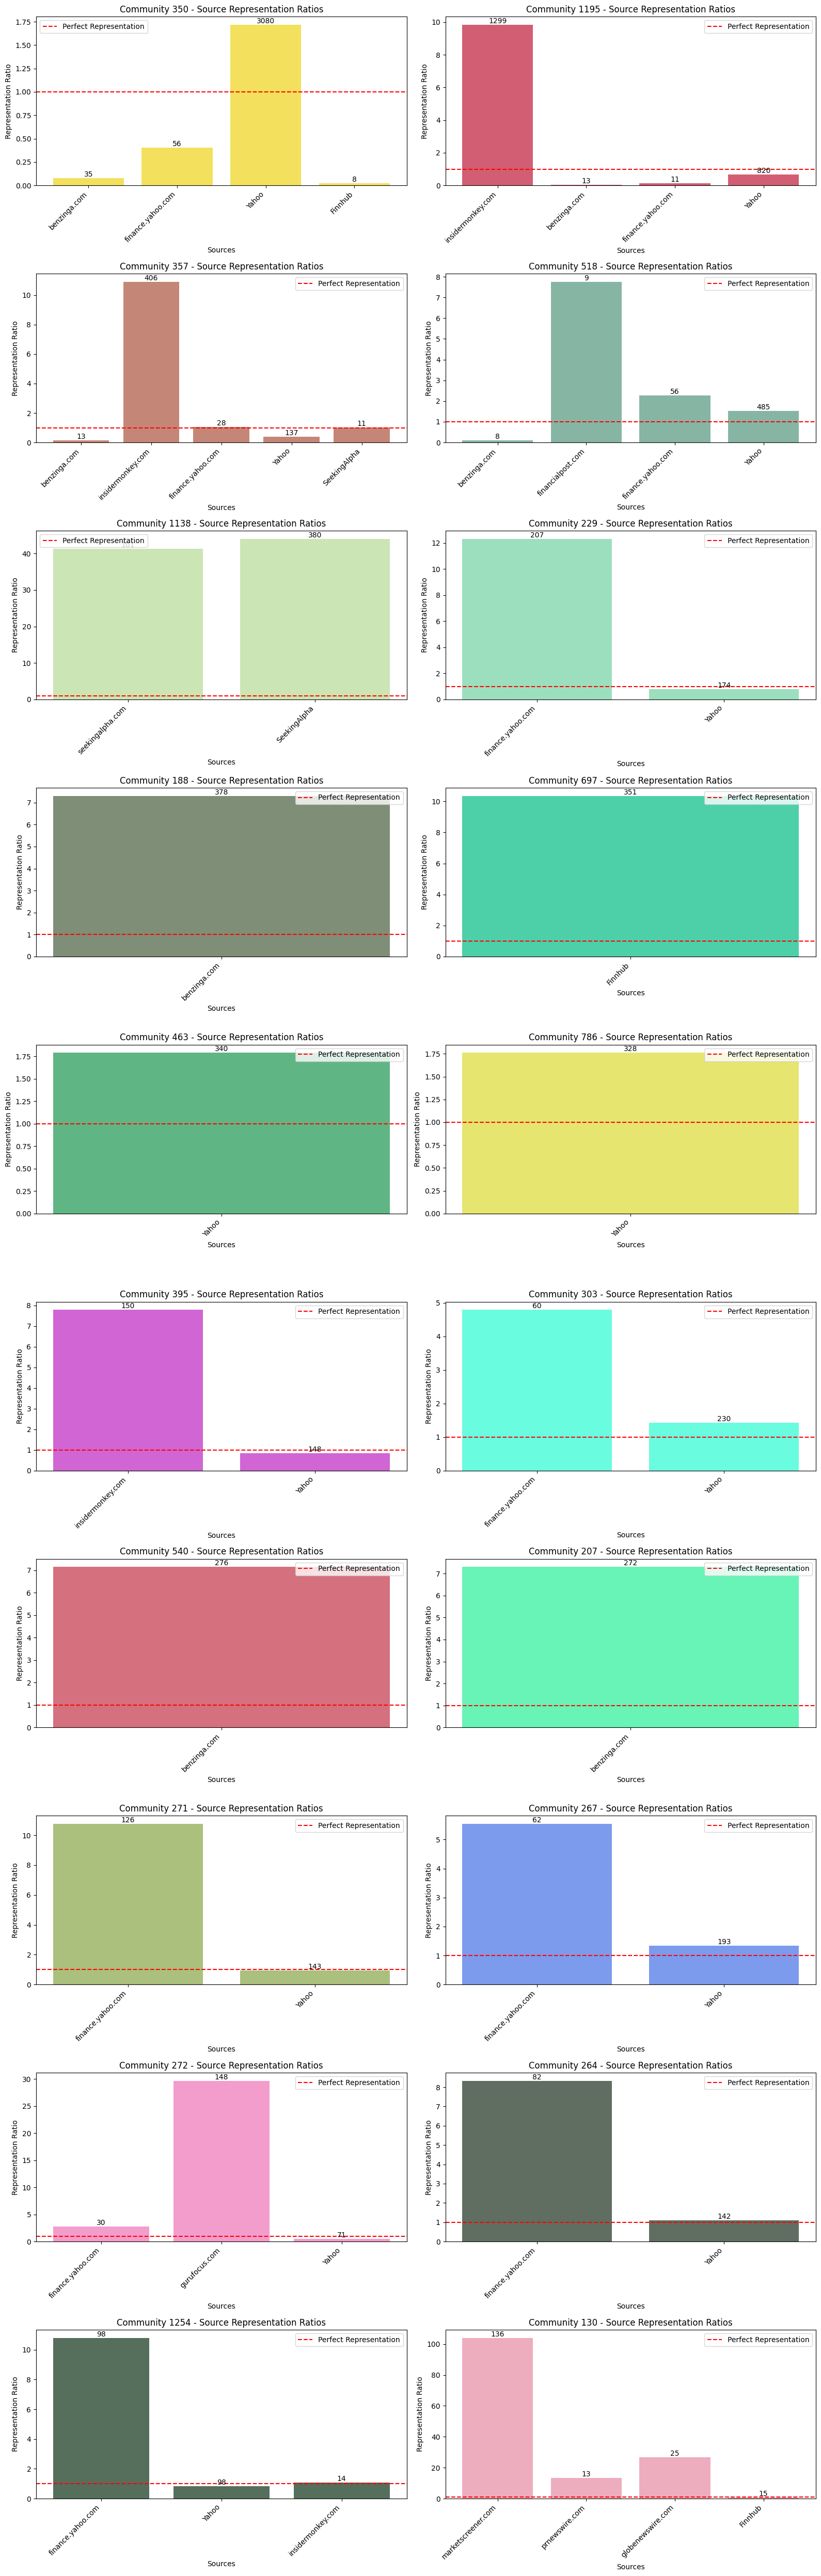

In [30]:
import matplotlib.pyplot as plt
from collections import Counter

# Total dataset size
total_dataset_size = len(reddit.df)

# Total count of each source in the dataset
source_counts = reddit.df['source'].value_counts()

# Prepare the subplots layout
num_communities = len(top_community_indices)
cols = 2  # Number of columns in the grid
rows = (num_communities + cols - 1) // cols  # Calculate rows based on the number of communities

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5), squeeze=False)
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each community index
for idx, community_index in enumerate(top_community_indices):
    ax = axes[idx]  # Select the subplot for this community

    # Subset for the current community
    community_data = reddit.df[reddit.df['community'] == community_index]
    
    # Size of the current cluster
    cluster_size = len(community_data)
    
    # Count of each source in the current cluster
    community_sources = Counter(community_data['source'])
    
    sources = []
    ratios = []
    counts = []
    
    for source, cluster_source_count in community_sources.items():
        # Exclude sources with fewer than 8 occurrences
        if cluster_source_count < 8:
            continue
        
        # Calculate the expected count for this source in the cluster
        expected_count = source_counts[source] * (cluster_size / total_dataset_size)
        
        # Calculate the ratio
        ratio = cluster_source_count / expected_count if expected_count > 0 else 0
        
        sources.append(source)
        ratios.append(ratio)
        counts.append(cluster_source_count)
    
    # Only plot if there are valid sources
    if sources:
        # Plot the results
        bars = ax.bar(sources, ratios, color=colors[community_index], alpha=0.7)
        
        # Add counts as labels on top of bars
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f"{count}", ha='center', va='bottom')
        
        ax.axhline(1, color="red", linestyle="--", label="Perfect Representation")
        ax.set_title(f"Community {community_index} - Source Representation Ratios")
        ax.set_xlabel("Sources")
        ax.set_ylabel("Representation Ratio")
        ax.legend()
        ax.set_xticks(range(len(sources)))
        ax.set_xticklabels(sources, rotation=45, ha='right')

# Remove any unused subplots
for idx in range(len(top_community_indices), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## 9. PCY Algorithm

The PCY algorithm uncovers frequently co-occurring words in the news articles and reddit data, revealing underlying themes and topics. This is analysed with the stock data average gradients to see if there is a correlation between the frequent word pairs and the stock price movements. We use PCY instead of Apriori since the datasets are so large. Additionally we focused on all the data, as looking as each cluster individually proved to be hard to interpret. Association rules are generated to identify common word pairs and their support and confidence values. A Scatter plot of frequent words pairs over their average gradient change is the main visualistion plot type. Additional plots like a network graph and word cloud are created to visualize the results, as well as a summarise function (not called in main).

Structure:
* Gradient Calculation
* PCY Algorithm
* Association Rule Generation
* Scatter plot of Pair Gradients
* Network Graph Visualization
* Word Cloud Visualization
* Summarise Findings Function
* Clean Reddit data functions
* main()

In [15]:
import pandas as pd
import ast
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import time
import networkx as nx
from adjustText import adjust_text
import re
import string
import nltk
from nltk.corpus import stopwords
np.random.seed(42) # somewhat reproducible results

nltk.download('stopwords')
    
stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "Nvidia": "NVDA",
    "Tesla": "TSLA",
    "Amazon": "AMZN",
    "Google": "GOOGL",
    "Meta": "META"
}

### Gradient Calculation

def average_gradient(df, stock, date_time, t):
    """
    Calculate the average gradient for a given stock around a specified date and time.
    
    Parameters:
    - df (DataFrame): The dataframe containing Date, stock prices as columns.
    - stock (str): The stock symbol for which to calculate the gradient (e.g., 'AAPL').
    - date_time (str or datetime): The reference date and time as a string or datetime object.
    - t (int): Number of timesteps before and after the date_time to calculate the gradient.
    
    Returns:
    - float: The average gradient (price change per timestep).
    """
    # Ensure date_time is in datetime format
    date_time = pd.to_datetime(date_time)

    # Determine indices for `t` steps before and `t` steps after, even if `date_time` is not in the data
    before_indices = df.index[df['Date'] <= date_time].to_numpy()[-(t[0]+1):]  # Last `t` steps before or equal
    after_indices = df.index[df['Date'] > date_time].to_numpy()[:t[1]]      # First `t` steps after

    if len(before_indices) < t[0]+1 or len(after_indices) < t[1]:
        return None, None
    
    after_indices = np.sort(np.append(after_indices, before_indices[-1]))
    before_prices = df.loc[before_indices, stock].to_numpy()
    avg_gradient_before = np.gradient(before_prices).mean()

    after_prices = df.loc[after_indices, stock]
    avg_gradient_after = np.gradient(after_prices).mean()

    return avg_gradient_before, avg_gradient_after

def get_stock_gradient_change_reddit(stock_df, reddit_df_series, t=(2, 2)):
    stock_input = reddit_df_series['stock']
    if isinstance(stock_input, list):
        stock_input = stock_input[0]  # Take the first element if it's a list
    if stock_input not in stock_dict and stock_input not in stock_dict.values():
        print(f"Error in stock_input: {stock_input}")
        return None

    if stock_input in stock_dict.values():
        stock = stock_input  # It's already a stock symbol
    elif stock_input in stock_dict:
        stock = stock_dict[stock_input]  # Convert company name to stock symbol
    else:
        print(f"Stock symbol not found for {stock_input}.")
        return None  # Not a valid stock symbol or company name
    date_time = reddit_df_series['timestamp']

    average_gradient_before, average_gradient_after = average_gradient(stock_df, stock, date_time, t)
    if average_gradient_before is None or average_gradient_after is None:
        print(f"Stock data not available for {stock} around {date_time}.")
        return None
    return average_gradient_after - average_gradient_before

### PCY Algorithm

def generate_hash_buckets(transactions, num_buckets):
    """
    Generate hash buckets for pairs of items in the first pass.
    
    Parameters:
    - transactions: List of transactions where each transaction is a list of items
    - num_buckets: Number of hash buckets to use
    
    Returns:
    - Dictionary mapping bucket indices to counts
    """
    buckets = {}
    for transaction in transactions:
        # Generate all possible pairs in the transaction
        for i in range(len(transaction)):
            for j in range(i + 1, len(transaction)):
                # Simple hash function: sum of indices modulo num_buckets
                bucket = (hash(transaction[i]) + hash(transaction[j])) % num_buckets
                buckets[bucket] = buckets.get(bucket, 0) + 1
    return buckets

def get_frequent_items(transactions, min_support):
    """
    Get frequent individual items from transactions.
    
    Parameters:
    - transactions: List of transactions
    - min_support: Minimum support threshold (as count)
    
    Returns:
    - Set of frequent items
    """
    item_counts = {}
    for transaction in transactions:
        for item in transaction:
            item_counts[item] = item_counts.get(item, 0) + 1
    
    return {item for item, count in item_counts.items() if count >= min_support}

def pcy_algorithm(cluster_data, min_support_pct=0.05, num_buckets=50):
    """
    Implement the PCY algorithm to find frequent pairs.
    
    Parameters:
    - cluster_data: DataFrame containing the cluster data
    - min_support_pct: Minimum support threshold as a percentage
    - num_buckets: Number of hash buckets to use
    
    Returns:
    - List of frequent pairs with their support counts
    """
    # Prepare transactions from cleaned text
    transactions = []
    for text in cluster_data['cleaned']:
        words = set(text.split())  # Using set to remove duplicates within transaction
        transaction = list(words)
        if len(transaction) > 0:  # Only add non-empty transactions
            transactions.append(transaction)
    
    num_transactions = len(transactions)
    min_support = int(min_support_pct * num_transactions)  # Convert percentage to count
    
    # First Pass: Count singles and hash pairs to buckets
    frequent_items = get_frequent_items(transactions, min_support)
    hash_buckets = generate_hash_buckets(transactions, num_buckets)
    
    # Create bitmap of frequent buckets
    frequent_buckets = {bucket for bucket, count in hash_buckets.items() 
                       if count >= min_support}
    
    # Second Pass: Count frequent pairs that hash to frequent buckets
    pair_counts = {}
    for transaction in transactions:
        # Consider only frequent items
        freq_items_in_trans = [item for item in transaction if item in frequent_items]
        
        # Count pairs that hash to frequent buckets
        for i in range(len(freq_items_in_trans)):
            for j in range(i + 1, len(freq_items_in_trans)):
                item1, item2 = freq_items_in_trans[i], freq_items_in_trans[j]
                bucket = (hash(item1) + hash(item2)) % num_buckets
                
                if bucket in frequent_buckets:
                    pair = tuple(sorted([item1, item2]))  # Ensure consistent ordering
                    pair_counts[pair] = pair_counts.get(pair, 0) + 1
    
    # Filter pairs by minimum support
    frequent_pairs = [(pair, count) for pair, count in pair_counts.items() 
                     if count >= min_support]
    
    return frequent_pairs

### Association Rules

def generate_association_rules(pairs_df, transactions, min_support_pct, confidence_threshold, lift_threshold):
    """
    Generate association rules from frequent pairs.

    Parameters:
    - pairs_df: DataFrame with columns ['pair', 'count'] from PCY results.
    - transactions: List of transactions used in the PCY algorithm.
    - min_support_pct: Minimum support threshold as a percentage.
    - confidence_threshold: Minimum confidence threshold to generate a rule.
    - lift_threshold: Minimum lift threshold to generate a rule.

    Returns:
    - DataFrame containing rules with 'antecedents', 'consequents', 'support', 'confidence', and 'lift'.
    """
    # Prepare data
    num_transactions = len(transactions)
    item_support = {}

    # Calculate support for individual items
    for transaction in transactions:
        for item in transaction:
            item_support[item] = item_support.get(item, 0) + 1

    # Normalize item support
    for item in item_support:
        item_support[item] /= num_transactions

    # Generate rules
    rules = []
    for _, row in pairs_df.iterrows():
        #     pairs_df['pair'] = pairs_df['pair'].apply(ast.literal_eval)  # Convert string to tuple
        pair = row['pair']
        #pair = ast.literal_eval(row['pair'])  # Convert string representation of the pair to a tuple
        pair_count = row['count']
        support_pair = pair_count / num_transactions
        
        # Filter pairs by minimum support
        if support_pair < min_support_pct:
            continue  # Skip pairs that don't meet the support threshold

        for item in pair:
            antecedent = item
            consequent = [x for x in pair if x != item][0]  # Other item in the pair
            
            # Calculate confidence and lift
            confidence = support_pair / item_support[antecedent] if item_support[antecedent] > 0 else 0
            lift = confidence / item_support[consequent] if item_support[consequent] > 0 else 0

            # Filter rules based on confidence and lift thresholds
            if confidence >= confidence_threshold and lift >= lift_threshold:
                rules.append({
                    'antecedents': [antecedent],
                    'consequents': [consequent],
                    'support': support_pair,
                    'confidence': confidence,
                    'lift': lift
                })

    return pd.DataFrame(rules)

def visualize_association_rules(rules_df, cluster_id, max_rules=20):
    """
    Visualize association rules for a cluster using a directed graph.
    
    Parameters:
    - rules_df: DataFrame containing association rules with 'antecedents', 'consequents', 'lift', and 'confidence'.
    - cluster_id: The ID of the cluster being analyzed.
    - max_rules: The maximum number of rules to visualize.
    """
    if rules_df.empty:
        print(f"No rules to visualize for cluster {cluster_id}")
        return
    
    # Limit to top rules by lift
    top_rules = rules_df.nlargest(max_rules, 'lift')
    
    # Create a directed graph
    G = nx.DiGraph()
    
    for _, rule in top_rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        for a in antecedents:
            for c in consequents:
                G.add_edge(a, c, lift=rule['lift'], confidence=rule['confidence'])
    
    # Generate positions for nodes
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for reproducibility
    
    # Node colors based on type (antecedents vs. consequents)
    node_colors = []
    for node in G.nodes():
        if any(node in list(rule['antecedents']) for _, rule in top_rules.iterrows()):
            node_colors.append('lightblue')  # Antecedents
        else:
            node_colors.append('lightgreen')  # Consequents
    
    # Edge weights based on lift
    edge_weights = [G[u][v]['lift'] for u, v in G.edges()]
    max_weight = max(edge_weights)
    scaled_weights = [w / max_weight * 5 for w in edge_weights]  # Scale for better visibility
    
    # Plot the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=1200,
        font_size=8,
        edge_color='gray',
        width=scaled_weights,
        arrowsize=15
    )
    
    # Add edge labels for lift and confidence
    edge_labels = {(u, v): f"Lift: {G[u][v]['lift']:.2f}\nConf: {G[u][v]['confidence']:.2f}"
                   for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    plt.title(f"Association Rules - Cluster {cluster_id}", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"Figures/pcy_plots/association_rules_cluster_{cluster_id}.png", dpi=300)
    plt.close()

#### Visualization functions
def visualize_pair_gradients(pairs_df, cluster_data, cluster_id, num_pairs=200, title="All Reddit Data"):
    """
    Visualize word pairs with corresponding price gradient changes.
    
    Args:
        pairs_df: Pre-computed DataFrame with columns ['pair', 'count']
        cluster_data: DataFrame containing the cluster data
        cluster_id: ID of the cluster being analyzed
    """
    # Take top pairs by count
    top_pairs_df = pairs_df.nlargest(num_pairs, "count").copy()
    
    # Pre-compute word sets for each text (only once)
    text_word_sets = {idx: set(text.split()) for idx, text in cluster_data['cleaned'].items()}
    
    # Calculate gradients for each pair
    gradients = []
    for _, row in top_pairs_df.iterrows():
        pair_set = set(row['pair'])
        matching_indices = [idx for idx, word_set in text_word_sets.items() if pair_set.issubset(word_set)]
        
        avg_gradient = (
            cluster_data.loc[matching_indices, 'stock_gradient_change'].mean() if matching_indices else 0
        )
        gradients.append(avg_gradient)
    
    top_pairs_df['avg_gradient'] = gradients
    top_pairs_df['abs_gradient'] = top_pairs_df['avg_gradient'].abs()

    print("\n avg grad \n", top_pairs_df['avg_gradient'].head())
    print("Abs \n", top_pairs_df['abs_gradient'].head())

    # Create scatter plot
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=top_pairs_df, x="count", y="avg_gradient", alpha=0.6)
    
    # Collect text annotations
    texts = []
    
    # Annotate top 10 most frequent pairs
    top_frequent = top_pairs_df.nlargest(10, "count")
    for _, row in top_frequent.iterrows():
        texts.append(
            plt.text(
                row['count'],
                row['avg_gradient'],
                f"{row['pair'][0]}-{row['pair'][1]}",
                fontsize=8,
                color='blue'
            )
        )
    
    # Annotate top 10 highest gradient pairs
    top_highest = top_pairs_df.nlargest(10, "avg_gradient")
    for _, row in top_highest.iterrows():
        texts.append(
            plt.text(
                row['count'],
                row['avg_gradient'],
                f"{row['pair'][0]}-{row['pair'][1]}",
                fontsize=8,
                color='green'
            )
        )
    
    # Annotate top 10 lowest gradient pairs
    top_lowest = top_pairs_df.nsmallest(10, "avg_gradient")
    for _, row in top_lowest.iterrows():
        texts.append(
            plt.text(
                row['count'],
                row['avg_gradient'],
                f"{row['pair'][0]}-{row['pair'][1]}",
                fontsize=8,
                color='red'
            )
        )

    # Adjust text positions to avoid overlaps
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="->", color="gray", lw=0.5),
        expand_text=(1.2, 1.2),
        expand_points=(1.2, 1.2),
        force_text=(0.8, 1.5)
    )

    plt.title(f"Price Gradient of Frequent Word Pairs for {title}")    
    plt.xlabel("Count (Frequency)")
    plt.ylabel("Average Price Gradient Change")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(f"Figures/pcy_plots/Cluster_{cluster_id}_scatter_{num_pairs}.png", dpi=300)
    plt.close()

    print(f"Saved scatter plot for Cluster {cluster_id} with top frequent and impactful pairs.")

    print("Top 10 highest gradient pairs:")
    print(top_highest[['pair', 'avg_gradient']])
    
    print("Top 10 lowest gradient pairs:")
    print(top_lowest[['pair', 'avg_gradient']])

def visualize_pair_network(pairs_df, cluster_id):
    """
    Create a network graph of frequent word pairs.
    
    Args:
        pairs_df: Pre-computed DataFrame with columns ['pair', 'count']
        cluster_id: ID of the cluster being analyzed
    """
    
    # Take top 30 pairs for visualization
    top_pairs_df = pairs_df.nlargest(30, "count")
    
    G = nx.Graph()
    
    # Add edges with weights
    for _, row in top_pairs_df.iterrows():
        G.add_edge(row['pair'][0], row['pair'][1], weight=row['count'])
    
    plt.figure(figsize=(12, 8))
    
    # Optimize layout calculation
    if len(G.nodes) > 50:
        pos = nx.spring_layout(G, k=1, iterations=50)
    else:
        pos = nx.spring_layout(G, k=1)
    
    # Draw network
    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
    max_weight = max(edge_weights)
    nx.draw(G, pos,
           with_labels=True,
           node_color="skyblue",
           edge_color=edge_weights,
           width=[w / max_weight * 3 for w in edge_weights],
           node_size=800,
           font_size=8)
    
    plt.title(f"Frequent Word Pair Network (Cluster {cluster_id})")
    #plt.tight_layout()
    plt.savefig(f"Figures/pcy_plots/Cluster_{cluster_id}_network.png", dpi=300)
    plt.close()

def visualize_wordcloud(cluster_data, cluster_id):
    """
    Generate and save a word cloud for a given cluster.
    """
    text = ' '.join(cluster_data['cleaned'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Keywords - Cluster {cluster_id}")
    plt.savefig(f"Figures/pcy_plots/Cluster_{cluster_id}_wordcloud.png", dpi=300)
    plt.close()

def summarize_critical_findings(cluster_data, frequent_pairs, cluster_id):
    """
    Summarize the most critical findings from the PCY analysis for a cluster.
    
    Args:
    - cluster_data: DataFrame containing the cluster data
    - frequent_pairs: List of tuples [(pair, count), ...] returned by PCY
    - cluster_id: ID of the cluster being analyzed
    
    Returns:
    - Dictionary containing the critical findings
    """
    findings = {}
    
    # 1. Basic Statistics
    findings['cluster_size'] = len(cluster_data)
    findings['num_frequent_pairs'] = len(frequent_pairs)
    
    # 2. Most Frequent Word Pairs
    if frequent_pairs:
        pairs_df = pd.DataFrame(frequent_pairs, columns=['pair', 'count'])
        top_pairs = pairs_df.nlargest(5, 'count')
        findings['top_pairs'] = [(pair, count) for pair, count in zip(top_pairs['pair'], top_pairs['count'])]
        
        # 3. Price Impact Analysis
        price_impact = []
        for pair, count in top_pairs.values:
            # Filter rows where both words in the pair exist
            mask = cluster_data['cleaned'].apply(
                lambda text: all(word in text.split() for word in pair)
            )
            avg_gradient = cluster_data[mask]['stock_gradient_change'].mean()
            price_impact.append((pair, avg_gradient))
        
        findings['price_impact'] = price_impact
        
        # 4. Overall Cluster Sentiment
        avg_gradient = cluster_data['stock_gradient_change'].mean()
        findings['avg_price_impact'] = avg_gradient
    
    # Print summary
    print(f"\n=== Critical Findings for Cluster {cluster_id} ===")
    print(f"Cluster Size: {findings['cluster_size']}")
    print(f"Number of Frequent Pairs: {findings['num_frequent_pairs']}")
    
    if frequent_pairs:
        print("\nTop 5 Most Frequent Word Pairs:")
        for pair, count in findings['top_pairs']:
            print(f"  {pair[0]} & {pair[1]}: {count} occurrences")
        
        print("\nPrice Impact of Top Pairs:")
        for pair, impact in findings['price_impact']:
            impact_str = "positive" if impact > 0 else "negative"
            print(f"  {pair[0]} & {pair[1]}: {impact_str} ({impact:.4f})")
        
        print(f"\nOverall Cluster Price Impact: {findings['avg_price_impact']:.4f}")
    
    return findings

#### Clean Reddit Data
def clean_ad_content(text):
    motley_pattern = r'^founded in 1993, the motley fool is a financial services company dedicated to making the world smarter, happier, and richer\..*?learn more'
    zacks_pattern = r'^we use cookies to understand how you use our site and to improve your experience\..*?terms of service apply\.'
    cleaned_text = re.sub(motley_pattern, '', text, flags=re.DOTALL)
    if re.search(zacks_pattern, text, flags=re.DOTALL):
        return None  # Remove the entire row if it matches the Zacks pattern
    return re.sub(zacks_pattern, '', cleaned_text, flags=re.DOTALL)

def is_valid_body(text):
    return text is not None and len(text) >= 30

def clean_text(text):
    """Standardizes and cleans text by lowercasing, removing punctuation, and extra whitespace."""
    try:
            text = text.lower()  # Lowercasing
            text = re.sub(r'(?:https?://|www\.)[^\s]+|(?:\b[a-zA-Z0-9.-]+\.(?:com|org|net|io)\b)', '', text)
            text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
            text = re.sub(r"[^a-zA-Z0-9\s]", "", text) # Remove special characters such as /, \, |, # etc.
            text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    except:
        print("Error in cleaning text")
        # print(text)
        # # print row number
        # print(self.df[self.df['body'] == text].index)
        # # print row
        # print(self.df[self.df['body'] == text])
    # Remove stopwords and words "one", "time", "reddit"
    stop_words = set(stopwords.words('english')).union({"one", "reddit", "time", "zacks", "rank", "motley", "fool", "cookies",
        "terms", "service", "privacy", "policy", "contact", "us", "advertising",
        "about", "careers", "help", "site", "map", "copyright", "trademark",
        "disclaimer", "accessibility", "preferences", "newsletter", "feedback",
        "use", "site", "constitutes", "acceptance", "user", "agreement", "please",
        "password", "forgot", "username", "email", "email", "password", "username",
        "dont", "know", "company", "return", "stock", "market", "investment",
        "herein", "represented", "said", "anything", "even", "like", "people", "get", "would", "got", 
        "last", "went", "see", "look", "looked", "looking", "also", "could", "know", "knows", "knowing", "known",
        "deleted", "removed", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15",
        "anything", "seen", "im", "pretty", "much", "since", "still", "thats", "thing", "things", "though", "thought",
        "isnt", "youre", "theyre", "dont", "doesnt", "didnt", "cant", "couldnt", "wont", "wouldnt", "shouldnt", "shoudlnt",
        "put", "day", "way", "think", "actually", "put", "still", "back", "go", "going", "gone", "went", "come", "coming", "came",
        "want", "many", "every", "really", "come", "feel", "feeling", "felt", "make", "makes", "made", "made", "made", "made",
        "friend", "asked", "make", "going", " want", "enough", "kind", "kinda", "kind", "kinda", "kind", "kinda", "kind", "kinda",
        "going", "really", "everything", "work", "need", "needmake", "say", "back", "family","human", "told",
        "anyone", "theres", "take", "place", "bot", "questions", "automatically", "action"
        "comment", "submission", "post", "give", "may", "everyone", "someone", "something", "nothing", "anything",
        "ive", "wanted", "around", "part", "without", "ask", "already", "use", "used", "using", "uses", "user", "users",
        "else", "wife", "husband", "son", "daughter", "mother", "father", "brother", "sister", "cousin", "aunt", "uncle",
        "one","two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve", "thirteen", "fourteen",})
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text


##### MAIN ### 
if __name__ == "__main__":
    # Paths
    PATH_COMMUNITIES = r'Data\GraphData\news_communities.csv'
    PATH_REDDIT = r'Data\final\Reddit_2021_to_2024_with_sentiment.csv'
    PATH_STOCK_DATA = r'Data\StockData\Stock_prices_2021_to_2024.csv'

    MIN_CLUSTER_SIZE = 50  # Minimum cluster size
    TIME = (2, 2) # Number of timesteps to look before and after the date_time to calculate the gradient.
    # a timestep is a row in the stock data which contains opening and closing price for each day. 
    # So (2,2) timesteps is looking at 1 day (2 prices) before and 1 day after the date_time.

    #### LOAD NEWS DATA ####
    df_communities = pd.read_csv(PATH_COMMUNITIES)
    print("Length of df_communities:", len(df_communities))
    # summary of df_communities
    #print("Summary of df_communities:\n", df_communities.describe())
    # Convert stock column from string representation of list to actual list
    df_communities['stock'] = df_communities['stock'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Remove any rows where community value is missing/NaN which means that the article was not assigned to a community
    df_communities.dropna(subset=['community'], inplace=True)
    print("After removing rows where community is NaN:", len(df_communities))
    # Convert community values to integers (handles cases where they may be floats)
    df_communities['community'] = df_communities['community'].apply(lambda x: int(x) if isinstance(x, float) else x)
    # Convert timestamp strings to datetime objects
    df_communities['timestamp'] = pd.to_datetime(df_communities['timestamp'])
    # Remove timezone info from timestamps to match stock data format
    df_communities['timestamp'] = df_communities['timestamp'].dt.tz_localize(None)

    #### LOAD REDDIT DATA ####
    # Combine title and body for sentiment analysis
    reddit_df = pd.read_csv(PATH_REDDIT)
    #print("Length of reddit_df:", len(reddit_df))
    # make sure timestamp is in datetime format
    reddit_df['timestamp'] = pd.to_datetime(reddit_df['timestamp'])
    reddit_df['timestamp'] = reddit_df['timestamp'].dt.tz_localize(None)
    # Rename 'source' column to 'Source'
    reddit_df = reddit_df.rename(columns={"source": "Source"})
    # Preprocess reddit_df['stock'] to match company_colors keys
    reddit_df['stock'] = reddit_df['stock'].replace(stock_dict)    
    # Combine title and body 
    #reddit_df['cleaned'] = reddit_df['title'] + ' ' + reddit_df['body'].fillna('')
    reddit_df['cleaned'] = reddit_df['full_text']
    # clean the text by converting to lowercase
    reddit_df['cleaned'] = reddit_df['cleaned'].astype(str).str.lower()
    # Apply the cleaning function-unwanted ad-related content (just in case it also is in the reddit data)
    original_clean = reddit_df['cleaned'].copy()
    reddit_df['cleaned'] = reddit_df['cleaned'].apply(clean_ad_content)
    # Remove stop words and reddit-specific words from bad spelling and online-linguistics
    reddit_df['cleaned'] = reddit_df['cleaned'].apply(lambda x: clean_text(x))
    # Drop rows where 'cleaned' is None or contains empty strings or very short content
    reddit_df = reddit_df[reddit_df['cleaned'].apply(is_valid_body)]
    # Re-index both original and cleaned data to align properly for comparison
    original_clean_aligned = original_clean.loc[reddit_df.index]
    # Convert it to a string just in case its a list
    reddit_df['stock'] = reddit_df['stock'].apply(lambda x: x if isinstance(x, str) else x)
    #print("\nType of reddit_df['stock']:", type(reddit_df['stock']))
    #print("Unique values in reddit_df['stock']:", reddit_df['stock'].unique())

    #### LOAD STOCK DATA ####
    df_stock = pd.read_csv(PATH_STOCK_DATA)
    df_stock['Date'] = pd.to_datetime(df_stock['Date'])
    # data time range of stock data
    print("\nData time range of stock data:", df_stock['Date'].min(), "to", df_stock['Date'].max())
    # data time range of df_communities
    print("Data time range of df_communities:", df_communities['timestamp'].min(), "to", df_communities['timestamp'].max())
    # data time range of reddit_df
    print("Data time range of reddit_df:", reddit_df['timestamp'].min(), "to", reddit_df['timestamp'].max())
    
    # plot histogram of dates for stock data overlayed with df_communities
    plt.hist(df_stock['Date'], bins=100, alpha=0.5, label='Stock Data')
    plt.hist(df_communities['timestamp'], bins=100, alpha=0.5, label='df_communities')
    plt.legend()
    plt.title("Dates Histogram")
    plt.xlabel("Date")
    plt.ylabel("Frequency")
    plt.savefig("Figures/dates_histogram.png")
    plt.close()

    #### PREPROCESS GRADIENT DATA ####
    # Remove rows outside of stock data range so we only keep data from the last 3 years
    df_communities = df_communities[df_communities['timestamp'] >= df_stock['Date'].min()]
    df_communities = df_communities[df_communities['timestamp'] <= df_stock['Date'].max()]
    print("After removing rows outside stock data range:",len(df_communities))
    reddit_df = reddit_df[reddit_df['timestamp'] >= df_stock['Date'].min()]
    reddit_df = reddit_df[reddit_df['timestamp'] <= df_stock['Date'].max()]
    print("After removing rows outside stock data range:",len(reddit_df))

    # Add stock gradient column to both news and reddit data
    df_communities['stock_gradient_change'] = df_communities.apply(lambda row: get_stock_gradient_change_reddit(df_stock, row, t=TIME), axis=1)
    df_communities.dropna(subset=['stock_gradient_change'], inplace=True)
    reddit_df['stock_gradient_change'] = reddit_df.apply(lambda row: get_stock_gradient_change_reddit(df_stock, row, t=TIME), axis=1)
    reddit_df.dropna(subset=['stock_gradient_change'], inplace=True)

    # histogram of stock_gradient_change
    plt.figure(figsize=(10, 5))
    plt.hist(df_communities['stock_gradient_change'], bins=100)
    plt.title("Stock Gradient Change Histogram")
    plt.xlabel("Stock Gradient Change")
    plt.ylabel("Frequency")
    plt.savefig("Figures/stock_gradient_change_histogram.png")
    plt.close()

    ##### CLUSTERS #####
    # Get the top 3 largest clusters
    cluster_sizes = df_communities['community'].value_counts()
    # histogram of cluster sizes
    plt.hist(cluster_sizes, bins=100)
    plt.title("Cluster Sizes Histogram")
    plt.xlabel("Cluster Size")
    plt.ylabel("Frequency")
    plt.savefig("Figures/cluster_sizes_histogram.png")
    plt.close()
    # Top 5 clusters
    top_5_clusters = cluster_sizes[cluster_sizes >= MIN_CLUSTER_SIZE].head(5).index.tolist()
    print(f"\nAnalyzing top 5 clusters with indexes: {top_5_clusters}")
    print("Top 5 Cluster sizes:", {cluster: cluster_sizes[cluster] for cluster in top_5_clusters})
    largest_cluster = top_5_clusters[0]
    second_largest_cluster = top_5_clusters[1]

    ##### PCY PARAMS #####
    NUM_PAIRS = 0.4  # Percentage of pairs to visualize for gradient analysis
    MAX_RULES = 20  # Maximum number of association rules to visualize
    NUM_BUCKETS = 200  # Number of hash buckets for PCY
    MIN_SUPPORT = 0.05  # Minimum support threshold as a percentage
    CONFIDENCE = 0.7
    LIFT = 1.5

    ### DO PCY FOR ALL REDDIT DATA
    def run_pcy_and_plot(df, data_name, plot_title, clustering=False, cluster_id=None):

        print(f"\nRunning PCY algorithm for {data_name}...")
        
        if clustering:
            df = df[df['community'] == cluster_id]
        # get all transactions
        transactions = [list(set(text.split())) for text in df['cleaned']]

        # Run PCY algorithm - takes about 2mins
        start_time = time.time()
        frequent_pairs_all = pcy_algorithm(df, min_support_pct=MIN_SUPPORT, num_buckets=NUM_BUCKETS)
        pcy_time = time.time() - start_time
        print(f"PCY algorithm for all data: {pcy_time:.2f} seconds")

        #Analyze and visualize results
        if frequent_pairs_all:
            print(f"Found {len(frequent_pairs_all)} frequent pairs in the dataset.")
            # Convert to DataFrame for easier processing
            pairs_df = pd.DataFrame(frequent_pairs_all, columns=['pair', 'count'])
            pairs_df['support'] = pairs_df['count'] / len(df)

            # Save frequent pairs to CSV
            pairs_df.to_csv(f"{data_name}_pcy_pairs.csv", index=False)
            print(f"Saved all data PCY pairs to '{data_name}_pcy_pairs.csv'.")

            # Generate association rules
            rules_df = generate_association_rules(pairs_df, transactions, min_support_pct=MIN_SUPPORT,
                confidence_threshold=CONFIDENCE,lift_threshold=LIFT)
            if not rules_df.empty:
                visualize_association_rules(rules_df, cluster_id=data_name, max_rules=MAX_RULES)

            # Pair gradients visualization plotting with different percentages of all frequent pairs found
            percentages = [NUM_PAIRS, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40]
            for percentage in percentages:
                num_pairs = max(100, int(percentage * len(df)))
                print(f"Visualizing top {num_pairs} pair gradients for all data (percentage: {percentage*100:.0f}%)...")
                visualize_pair_gradients(pairs_df, df, cluster_id=data_name, num_pairs=num_pairs, title=plot_title)
            
            # Network visualization
            visualize_pair_network(pairs_df, cluster_id=data_name)

            # Wordcloud visualization
            visualize_wordcloud(df, cluster_id=data_name)

            # Generate association rules
            rules_df = generate_association_rules(pairs_df, transactions, min_support_pct=MIN_SUPPORT, confidence_threshold=CONFIDENCE, lift_threshold=LIFT)
            if not rules_df.empty:
                visualize_association_rules(rules_df, cluster_id=data_name, max_rules=MAX_RULES)

            print("Analysis and visualizations for all data completed.")
        else:
            print("No frequent pairs found for the entire dataset.")

    run_pcy_and_plot(reddit_df, data_name= "All_Reddit_Data", plot_title="All Reddit Data")
    run_pcy_and_plot(df_communities, data_name="All_News_Data", plot_title="All News Data")
    run_pcy_and_plot(df_communities, data_name="Largest_News_Cluster", plot_title="Largest News Cluster", clustering=True, cluster_id=largest_cluster)

    ### LOAD PCY RESULTS FROM CSV
    # transactions = [list(set(text.split())) for text in df_communities['cleaned']]
    # # load all_data_pcy_pairs.csv
    # pairs_df = pd.read_csv("all_data_pcy_pairs.csv")
    # pairs_df['pair'] = pairs_df['pair'].apply(ast.literal_eval)  # Convert string to tuple

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jbhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Length of df_communities: 31501
After removing rows where community is NaN: 17737

Data time range of stock data: 2021-12-01 09:30:00 to 2024-10-31 16:00:00
Data time range of df_communities: 2021-01-03 19:51:27 to 2024-11-19 14:12:00
Data time range of reddit_df: 2021-12-01 00:06:09 to 2024-10-31 22:38:56
After removing rows outside stock data range: 15154
After removing rows outside stock data range: 8734
Stock data not available for AMZN around 2021-12-01 12:51:24.
Stock data not available for AMZN around 2021-12-01 15:29:34.
Stock data not available for TSLA around 2021-12-01 16:46:46.
Stock data not available for AMZN around 2021-12-01 18:16:41.
Stock data not available for AMZN around 2024-10-31 10:11:36.
Stock data not available for AAPL around 2024-10-31 10:22:08.
Stock data not available for MSFT around 2024-10-31 11:27:57.
Stock data not available for AMZN around 2024-10-31 11:34:17.
Stock data not available for AAPL around 2024-10-31 12:25:11.
Stock data not available for AA

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


Saved scatter plot for Cluster All_Reddit_Data with top frequent and impactful pairs.
Top 10 highest gradient pairs:
                     pair  avg_gradient
4140        (fuck, money)      0.711046
1116          (top, year)      0.659360
1119           (lot, top)      0.644583
5670         (elon, musk)      0.640496
2094  (absolutely, years)      0.575563
6271       (big, instead)      0.572454
6469          (big, full)      0.554215
1120         (first, top)      0.554052
3626      (support, well)      0.550061
6114    (comment, report)      0.548111
Top 10 lowest gradient pairs:
                  pair  avg_gradient
3328     (least, next)     -0.641385
2870    (another, job)     -0.594426
5818    (issues, well)     -0.528349
3338   (right, thanks)     -0.518205
2466       (new, show)     -0.492284
5053        (20, well)     -0.477319
414        (job, long)     -0.476698
2857      (lot, wrong)     -0.474730
2906  (another, thank)     -0.465155
4928    (called, read)     -0.462519
Visual

## 10. Correlation Analysis

Correlation analysis quantifies the relationships between sentiment scores and stock prices, providing a statistical basis for understanding their interplay.

Our correlation analysis examines:
- Lagged relationships between sentiment and price movements
- Different time windows (0-7 days)
- Company-specific patterns
- Visualization of correlation patterns

### 10.1 Sentiment vs Price change (Moving averages)

Plots moving averages of sentiment scores and percentage price changes for multiple stocks to visualize potential relationships between sentiment and stock performance over time. Furthermore, we compute correlations between the sentiment MA and the Stock Price MA.

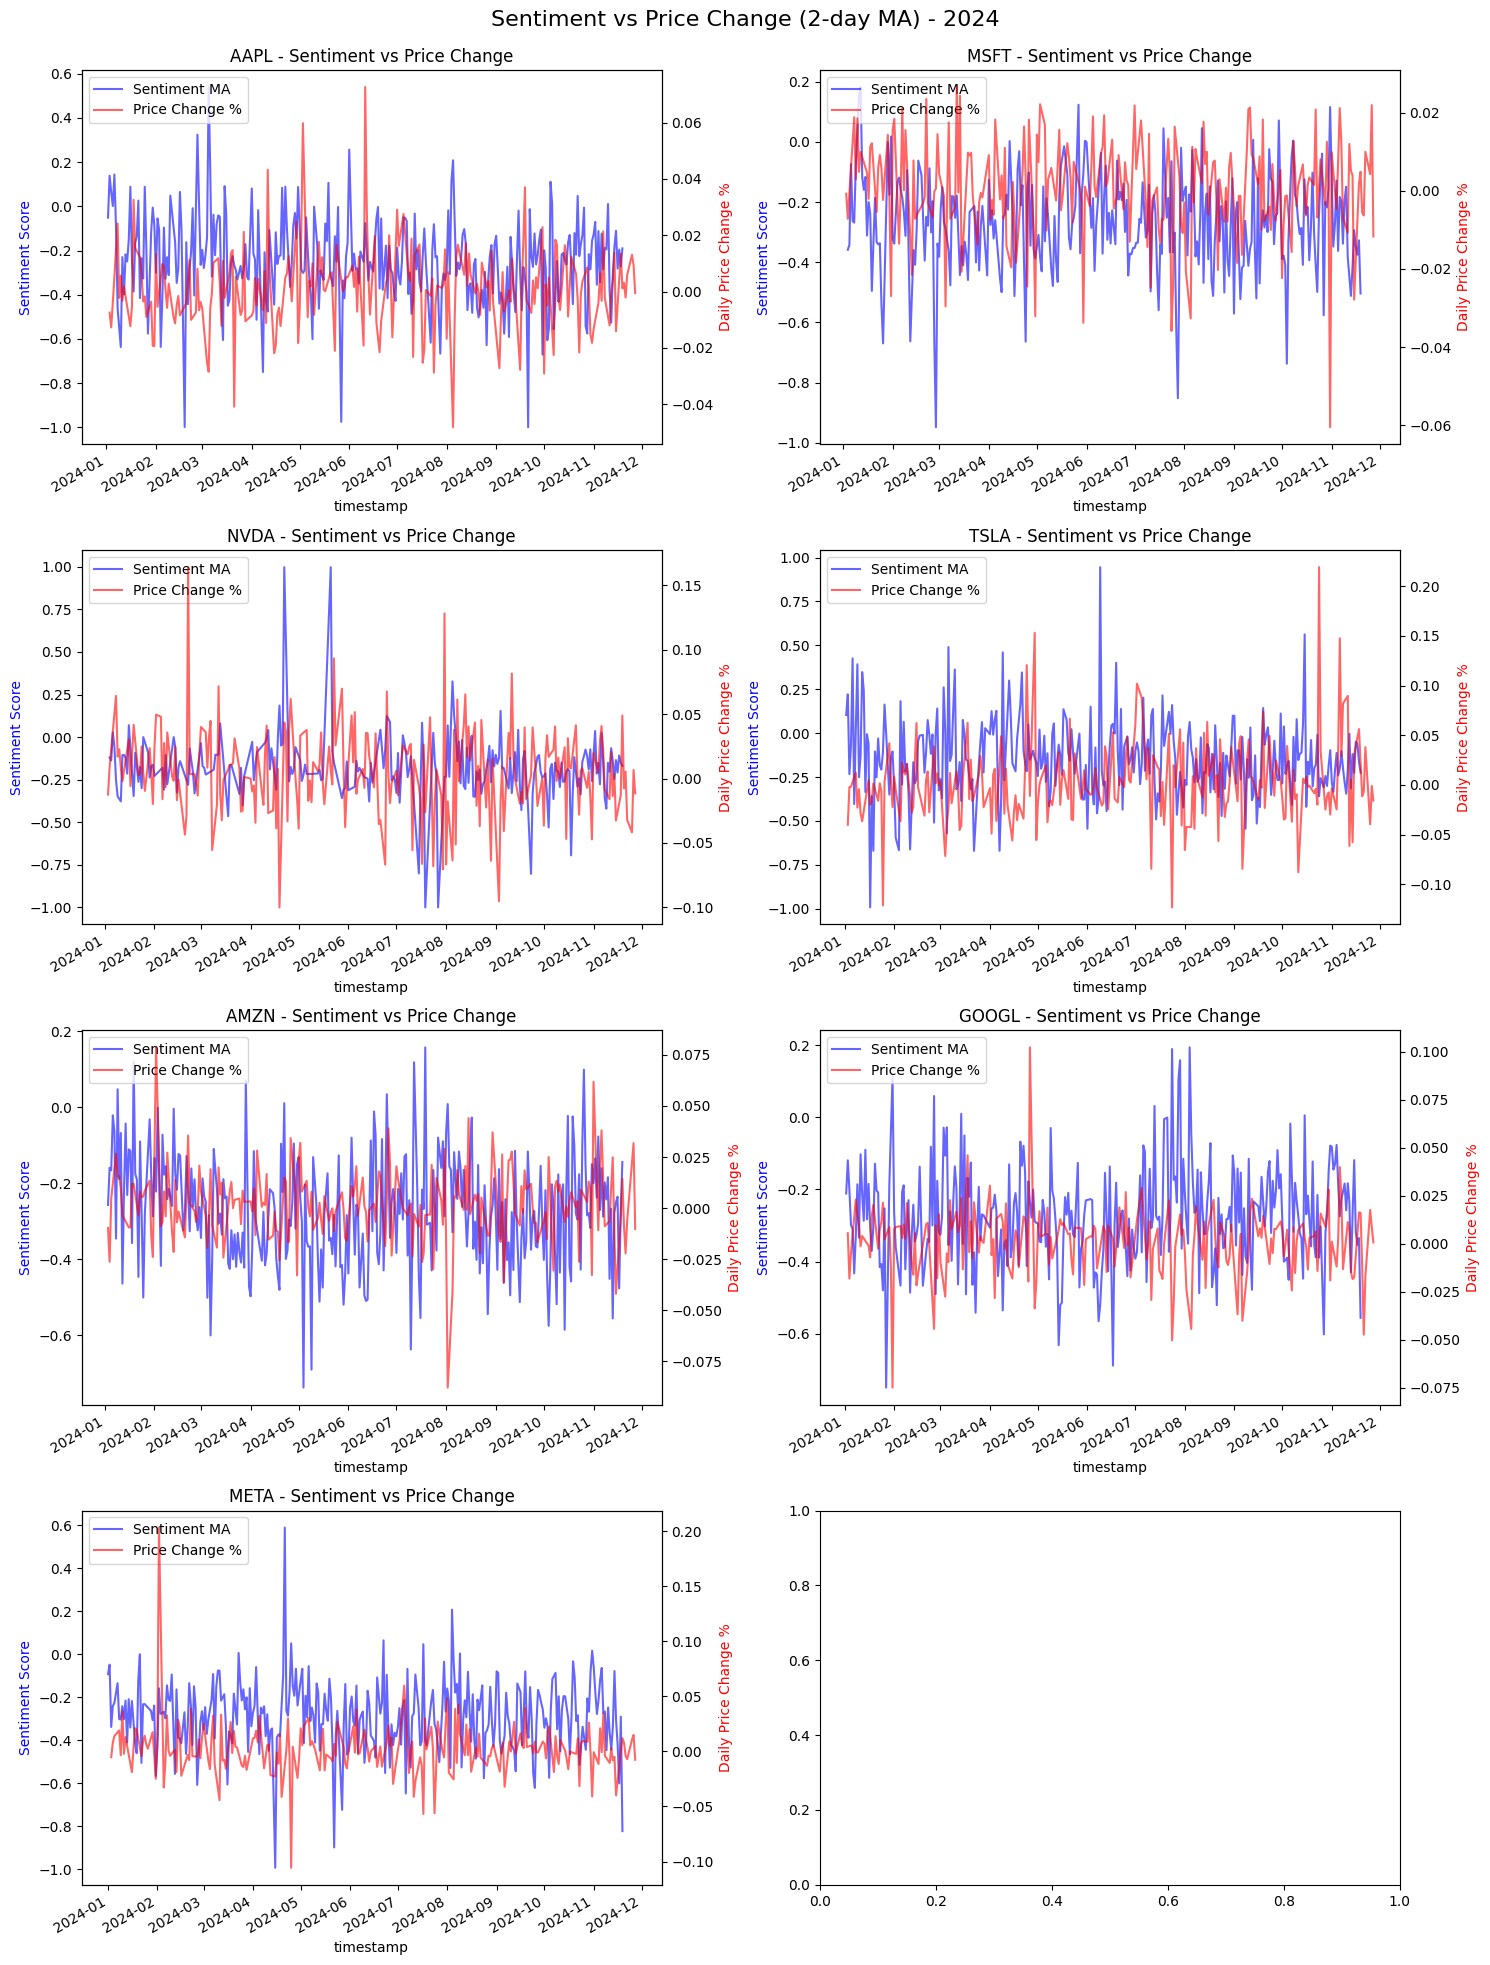


Correlations between sentiment and price changes (2024):
AAPL: -0.191
MSFT: -0.081
NVDA: -0.091
TSLA: -0.093
AMZN: -0.039
GOOGL: -0.233
META: -0.013


In [4]:
import pandas as pd

sentiment_data = pd.read_csv(r"Data\final\cleaned_combined_news_with_bodies_with_sentiment.csv")

# Convert timestamp to datetime and set as index
sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])

# Extract individual stocks from the list in 'stock' column
sentiment_data['stock'] = sentiment_data['stock'].apply(eval)
sentiment_expanded = sentiment_data.explode('stock')

# Filter for specific year (2024)
sentiment_expanded_2024 = sentiment_expanded[sentiment_expanded['timestamp'].dt.year == 2024]

# Calculate daily sentiment moving average (7-day window) for each stock
daily_sentiment = sentiment_expanded_2024.groupby(['stock', sentiment_expanded_2024['timestamp'].dt.date])['sentiment_score'].mean()
daily_sentiment = daily_sentiment.reset_index()
daily_sentiment['timestamp'] = pd.to_datetime(daily_sentiment['timestamp'])

# Calculate stock gradients (daily percentage change)
gradients = {}
for stock in all_stocks.columns[1:]:  # Skip the Date column
    # Filter stock data for 2024
    stock_data_2024 = all_stocks[all_stocks['Date'].dt.year == 2024]
    
    # Get end-of-day prices
    daily_prices = stock_data_2024[stock_data_2024['Date'].dt.time == pd.Timestamp('16:00:00').time()][['Date', stock]]
    daily_prices['Date'] = daily_prices['Date'].dt.date
    daily_prices.set_index('Date', inplace=True)
    
    # Calculate percentage change
    gradients[stock] = daily_prices[stock].pct_change()

# Create subplots with more space at the top
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

# Add main title to the figure with adjusted position
plt.subplots_adjust(top=0.95)  # Increase space at the top
fig.suptitle('Sentiment vs Price Change (2-day MA) - 2024', fontsize=16, y=0.98)

for idx, stock in enumerate(all_stocks.columns[1:]):
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    # Get stock-specific sentiment data
    stock_sentiment = daily_sentiment[daily_sentiment['stock'] == stock].copy()
    sentiment_ma = stock_sentiment.set_index('timestamp')['sentiment_score'].rolling(window=1).mean()
    
    # Plot sentiment MA
    sentiment_ma.plot(ax=ax1, color='blue', alpha=0.6, label='Sentiment MA')
    
    # Plot stock gradient
    gradients[stock].plot(ax=ax2, color='red', alpha=0.6, label='Price Change %')
    
    ax1.set_title(f'{stock} - Sentiment vs Price Change')
    ax1.set_ylabel('Sentiment Score', color='blue')
    ax2.set_ylabel('Daily Price Change %', color='red')
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
# Adjust layout after tight_layout to preserve the main title position
plt.subplots_adjust(top=0.95)  # This ensures the title doesn't overlap with subplots
plt.show()

# Calculate correlations for 2024
correlations = {}
for stock in all_stocks.columns[1:]:
    stock_sentiment = daily_sentiment[daily_sentiment['stock'] == stock].copy()
    sentiment_ma = stock_sentiment.set_index('timestamp')['sentiment_score'].rolling(window=1).mean()
    
    # Convert indices to datetime for proper alignment
    sentiment_idx = sentiment_ma.index.date
    gradient_idx = pd.to_datetime(gradients[stock].index)
    
    # Create aligned series
    common_dates = set(sentiment_idx).intersection(set(gradient_idx.date))
    if common_dates:
        sentiment_aligned = sentiment_ma[[d in common_dates for d in sentiment_idx]]
        gradients_aligned = gradients[stock][[d in common_dates for d in gradient_idx.date]]
        
        correlation = sentiment_aligned.corr(gradients_aligned)
        correlations[stock] = correlation

print("\nCorrelations between sentiment and price changes (2024):")
for stock, corr in correlations.items():
    print(f"{stock}: {corr:.3f}")

### 10.2 Sentiment vs Price change correlations with different time lags

Calculates and visualizes correlations between sentiment scores and price changes across varying time lags to analyze delayed market reactions to sentiment shifts.


Correlations by lag days:

AAPL:
Lag 0 days: -0.191
Lag 1 days: -0.109
Lag 2 days: 0.057
Lag 3 days: 0.059
Lag 4 days: 0.127
Lag 5 days: -0.052

MSFT:
Lag 0 days: -0.081
Lag 1 days: -0.008
Lag 2 days: 0.037
Lag 3 days: 0.061
Lag 4 days: -0.077
Lag 5 days: -0.131

NVDA:
Lag 0 days: -0.091
Lag 1 days: -0.003
Lag 2 days: 0.211
Lag 3 days: -0.041
Lag 4 days: 0.255
Lag 5 days: -0.057

TSLA:
Lag 0 days: -0.093
Lag 1 days: -0.068
Lag 2 days: -0.032
Lag 3 days: 0.028
Lag 4 days: 0.031
Lag 5 days: -0.039

AMZN:
Lag 0 days: -0.039
Lag 1 days: 0.103
Lag 2 days: 0.068
Lag 3 days: 0.023
Lag 4 days: 0.041
Lag 5 days: -0.023

GOOGL:
Lag 0 days: -0.233
Lag 1 days: -0.165
Lag 2 days: 0.007
Lag 3 days: 0.077
Lag 4 days: 0.035
Lag 5 days: -0.017

META:
Lag 0 days: -0.013
Lag 1 days: -0.043
Lag 2 days: -0.024
Lag 3 days: 0.043
Lag 4 days: -0.071
Lag 5 days: -0.038


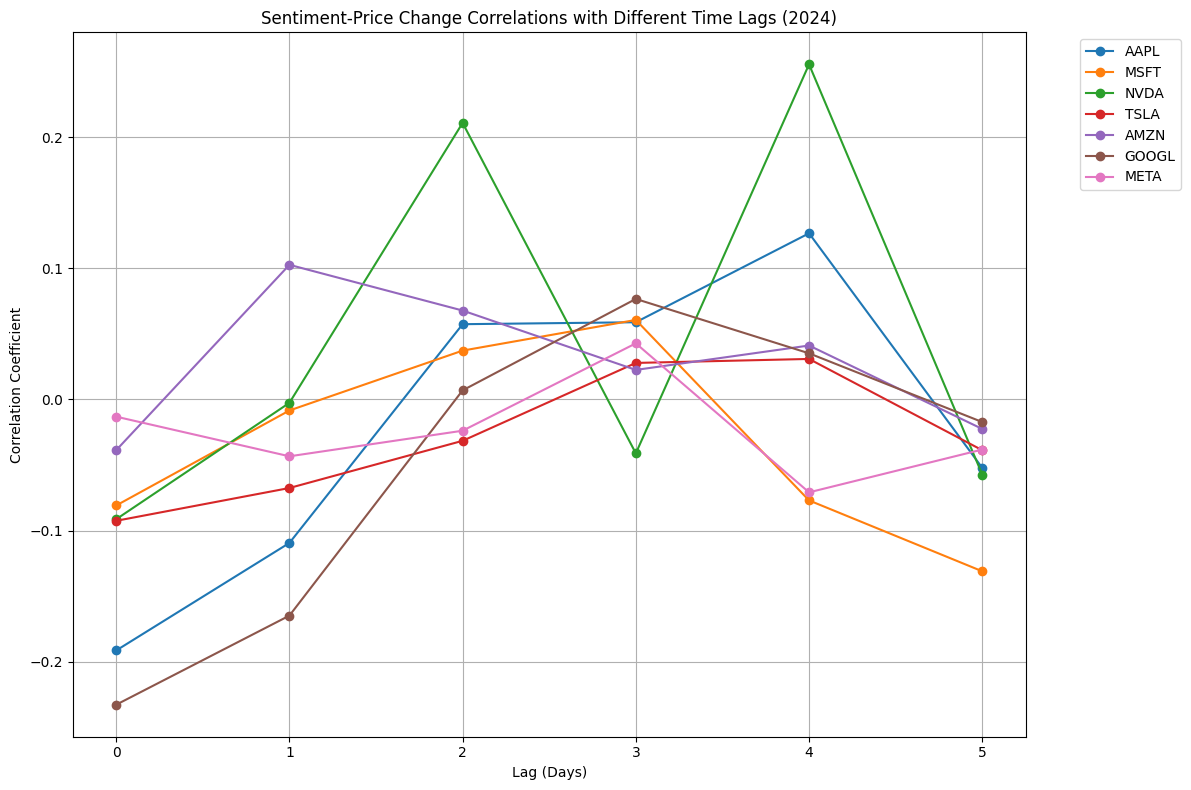

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

def load_and_prepare_data():
    # Read stock data
    stocks_close = pd.read_csv(r"Data\StockData\Googlefinance_stocks - Close_values.csv", skiprows=1)
    
    # Clean up column names - remove empty columns
    stocks_close = stocks_close.iloc[:, [0,1,3,5,7,9,11,13]]
    column_names = ['Date', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'GOOGL', 'META']
    stocks_close.columns = column_names
    
    # Convert price columns to float
    for col in column_names[1:]:
        stocks_close[col] = stocks_close[col].str.replace(',', '.').astype(float)
    
    # Clean and convert dates
    stocks_close['Date'] = stocks_close['Date'].str.replace('.', ':')
    stocks_close['Date'] = pd.to_datetime(stocks_close['Date'], format='%d/%m/%Y %H:%M:%S')
    stocks_close = stocks_close.sort_values('Date')
    
    # Read sentiment data
    sentiment_data = pd.read_csv(r"Data\final\cleaned_combined_news_with_bodies_with_sentiment.csv")
    sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
    sentiment_data['stock'] = sentiment_data['stock'].apply(eval)
    sentiment_expanded = sentiment_data.explode('stock')
    
    return stocks_close, sentiment_expanded

def calculate_lagged_correlations(stocks_close, sentiment_expanded, year=2024, max_lag_days=5):
    """Calculate correlations with different time lags"""
    
    # Filter for specific year
    stocks_year = stocks_close[stocks_close['Date'].dt.year == year]
    sentiment_year = sentiment_expanded[sentiment_expanded['timestamp'].dt.year == year]
    
    # Calculate daily price changes
    daily_returns = {}
    for stock in stocks_close.columns[1:]:
        daily_prices = stocks_year[stocks_year['Date'].dt.time == pd.Timestamp('16:00:00').time()][['Date', stock]]
        daily_prices.set_index('Date', inplace=True)
        daily_returns[stock] = daily_prices[stock].pct_change()
    
    # Calculate daily sentiment
    daily_sentiment = sentiment_year.groupby(['stock', sentiment_year['timestamp'].dt.date])['sentiment_score'].mean()
    daily_sentiment = daily_sentiment.reset_index()
    daily_sentiment['timestamp'] = pd.to_datetime(daily_sentiment['timestamp'])
    
    # Calculate correlations for different lags
    lag_correlations = {stock: [] for stock in stocks_close.columns[1:]}
    
    for lag in range(max_lag_days + 1):
        for stock in stocks_close.columns[1:]:
            stock_sentiment = daily_sentiment[daily_sentiment['stock'] == stock].copy()
            
            # Convert timestamp to date for proper alignment
            stock_sentiment['date'] = stock_sentiment['timestamp'].dt.date
            stock_sentiment = stock_sentiment.set_index('date')
            sentiment_series = stock_sentiment['sentiment_score']
            
            # Convert returns index to date
            returns_series = daily_returns[stock].copy()
            returns_series.index = pd.to_datetime(returns_series.index).date
            
            # Shift sentiment forward (to predict future returns)
            if lag > 0:
                sentiment_series = sentiment_series.shift(lag)
            
            # Align the series and calculate correlation
            aligned_data = pd.DataFrame({
                'sentiment': sentiment_series,
                'returns': returns_series
            })
            aligned_data = aligned_data.dropna()
            
            if len(aligned_data) > 0:
                correlation = aligned_data['sentiment'].corr(aligned_data['returns'])
                lag_correlations[stock].append(correlation)
            else:
                lag_correlations[stock].append(np.nan)
    
    return lag_correlations

def plot_lag_correlations(lag_correlations, max_lag_days=5):
    """Plot correlation vs lag days for each stock"""
    plt.figure(figsize=(12, 8))
    
    for stock, correlations in lag_correlations.items():
        plt.plot(range(max_lag_days + 1), correlations, marker='o', label=stock)
    
    plt.title('Sentiment-Price Change Correlations with Different Time Lags (2024)')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Add correlation values as text
    print("\nCorrelations by lag days:")
    for stock, correlations in lag_correlations.items():
        print(f"\n{stock}:")
        for lag, corr in enumerate(correlations):
            print(f"Lag {lag} days: {corr:.3f}")
    
    plt.show()

def main():
    stocks_close, sentiment_expanded = load_and_prepare_data()
    lag_correlations = calculate_lagged_correlations(stocks_close, sentiment_expanded)
    plot_lag_correlations(lag_correlations)

if __name__ == "__main__":
    main()

## 10b
Find clusters with highest correlation between stock change and sentiment

In this section we:

- Describe distribution of clusters

- Describe distribution of mean correlation for the clusters

- Describe clusters with the largest correlation (negative and positive)

What we achieve is an insightful view into what makes a news article correlate with a stock. Here we order the clusters by the average correlation and in the end, we can see what kind of terms come to surface in these clusters. We find that negative articles tend to have a higher correlation with stock changes.

In [16]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

PATH_COMMUNITIES = r'Data\GraphData\news_communities.csv'
PATH_STOCK_DATA = r'Data\StockData\Stock_prices_2021_to_2024.csv'

In [17]:
df_communities = pd.read_csv(PATH_COMMUNITIES)
df_communities['stock'] = df_communities['stock'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_communities.dropna(subset=['community'], inplace=True)
df_communities['community'] = df_communities['community'].apply(lambda x: int(x) if isinstance(x, float) else x)
df_communities['timestamp'] = pd.to_datetime(df_communities['timestamp'])
df_communities['timestamp'] = df_communities['timestamp'].dt.tz_localize(None)

df_stock = pd.read_csv(PATH_STOCK_DATA)
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

# Remove rows outside of stock data range
df_communities = df_communities[df_communities['timestamp'] >= df_stock['Date'].min()]
df_communities = df_communities[df_communities['timestamp'] <= df_stock['Date'].max()]
print("\nAfter removing rows outside stock data range:")
print(len(df_communities))


After removing rows outside stock data range:
15154


### Add stock delta column

In order to calculate the statistics we add the stock delta differential to a dataframe. Then we can use most of the built in summarization functionality in pandas, which makes the remaining process a lot more trivial.

In [20]:
STOCK_DATE_COLUMN_NAME = 'Date'

def average_gradient(df, stock, date_time, t):
    """
    Calculate the average gradient for a given stock around a specified date and time.
    
    Parameters:
    - df (DataFrame): The dataframe containing Date, stock prices as columns.
    - stock (str): The stock symbol for which to calculate the gradient (e.g., 'AAPL').
    - date_time (str or datetime): The reference date and time as a string or datetime object.
    - t (int): Number of timesteps before and after the date_time to calculate the gradient.
    
    Returns:
    - float: The average gradient (price change per timestep).
    """
    # Ensure date_time is in datetime format
    date_time = pd.to_datetime(date_time)

    #print("Important type check:", type(date_time), type(df['Date'][0]))
    
    # Determine indices for `t` steps before and `t` steps after, even if `date_time` is not in the data
    before_indices = df.index[df[STOCK_DATE_COLUMN_NAME] <= date_time].to_numpy()[-(t[0]+1):]  # Last `t` steps before or equal
    after_indices = df.index[df[STOCK_DATE_COLUMN_NAME] > date_time].to_numpy()[:t[1]]      # First `t` steps after

    if len(before_indices) < t[0]+1 or len(after_indices) < t[1]:
        return None, None
    
    #print(after_indices, before_indices)
    after_indices = np.sort(np.append(after_indices, before_indices[-1]))
    #print(after_indices)

    before_prices = df.loc[before_indices, stock].to_numpy()
    avg_gradient_before = np.gradient(before_prices).mean()

    after_prices = df.loc[after_indices, stock]
    avg_gradient_after = np.gradient(after_prices).mean()

    return avg_gradient_before, avg_gradient_after

stock_dict = {
    "Apple": "AAPL",
    "Microsoft": "MSFT",
    "NVIDIA": "NVDA",
    "Tesla": "TSLA",
    "Amazon": "AMZN",
    "Alphabet": "GOOGL",
    "Meta": "META"
}

def get_stock_gradient_change_reddit(stock_df, reddit_df_series, t=(2, 2)):
    # Get the stock symbol and date from the reddit data
    if reddit_df_series['stock'][0] not in stock_dict and reddit_df_series['stock'][0] not in stock_dict.values():
        return None
    
    #print(1)

    stock_input = reddit_df_series['stock'][0]

    if stock_input in stock_dict.values():
        stock = stock_input  # It's already a stock symbol
    elif stock_input in stock_dict:
        stock = stock_dict[stock_input]  # Convert company name to stock symbol
    else:
        return None  # Not a valid stock symbol or company name


    date_time = reddit_df_series['timestamp']

    average_gradient_before, average_gradient_after = average_gradient(stock_df, stock, date_time, t)

    #print(average_gradient_before, average_gradient_after)

    if average_gradient_before is None or average_gradient_after is None:
        return None
    
    

    return average_gradient_after - average_gradient_before


def populate_df_with_stock_gradient_change(stock_df, reddit_df):
    reddit_df['stock_gradient_change'] = reddit_df.apply(lambda row: get_stock_gradient_change_reddit(stock_df, row), axis=1)


populate_df_with_stock_gradient_change(df_stock, df_communities)
df_communities.dropna(subset=['stock_gradient_change'], inplace=True)

# Changes company from list to single company (First entry)
# This is destructive and the code above will not work after this step is run. Rerun from 10b if needed

df_communities['stock'] = df_communities['stock'].apply(lambda x: x[0] if isinstance(x, list) else x)

### Compute cluster metrics and save to file

In [ ]:
# Params
min_size = 50
max_size = 500

community_relevance = df_communities.groupby('community')['relevance'].mean().reset_index()

# Add the size of each community
community_size = df_communities.groupby('community')['relevance'].size().reset_index(name='size')

# Merge the size data with the mean relevance data
community_stats = community_relevance.merge(community_size, on='community')

filtered_stats = community_stats[(community_stats['size'] >= min_size) & (community_stats['size'] <= max_size)]

### Continued

In [ ]:
STATISTICS_FOLDER = 'Statistics_Clustercorrelation/' # Make sure to create folder before running

def get_stats_for_community(ID):
    print("Community ID:", ID)
    relevance = df_communities[df_communities['community'] == ID]['relevance'].mean()
    gradient_diff = df_communities[df_communities['community'] == ID]['stock_gradient_change'].mean()
    sentiment = df_communities[df_communities['community'] == ID]['sentiment_score'].mean()
    size = len(df_communities[df_communities['community'] == ID])
    word_freq = df_communities[df_communities['community'] == ID]['cleaned'].str.split(expand=True).stack().value_counts()
    top_sources = df_communities[df_communities['community'] == ID]['Source'].value_counts().head(3).index
    top_terms = word_freq.head(10).index

    return dict(ID_community = ID, relevance=relevance, gradient_diff=gradient_diff, sentiment=sentiment, size=size, top_terms=list(top_terms), top_sources=list(top_sources))

# Make table of top 5 communities
top_communities = filtered_stats.nlargest(5, 'relevance')
top_community_ids = top_communities['community'].to_list()
top_community_stats = [get_stats_for_community(ID) for ID in top_community_ids]
top_community_stats = pd.DataFrame(top_community_stats)

# Round numbers
top_community_stats['relevance'] = top_community_stats['relevance'].round(2)
top_community_stats['gradient_diff'] = top_community_stats['gradient_diff'].round(2)
top_community_stats['sentiment'] = top_community_stats['sentiment'].round(2)

top_community_stats.to_csv(STATISTICS_FOLDER + 'top_community_stats.csv', index=False)


# Make table of bottom 5 communities
bottom_communities = filtered_stats.nsmallest(5, 'relevance')
bottom_community_ids = bottom_communities['community'].to_list()
bottom_community_stats = [get_stats_for_community(ID) for ID in bottom_community_ids]
bottom_community_stats = pd.DataFrame(bottom_community_stats)

# Round numbers
bottom_community_stats['relevance'] = bottom_community_stats['relevance'].round(2)
bottom_community_stats['gradient_diff'] = bottom_community_stats['gradient_diff'].round(2)
bottom_community_stats['sentiment'] = bottom_community_stats['sentiment'].round(2)


bottom_community_stats.to_csv(STATISTICS_FOLDER + 'bottom_community_stats.csv', index=False)